In [1]:
# Run only once to install the dependencies
import sys

!pip install -q rdflib networkx matplotlib
!{sys.executable} -m pip install rdflib networkx matplotlib --user

     |████████████████████████████████| 235kB 2.8MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from rdflib import Graph as RDFGraph
from rdflib.extras.external_graph_libs import rdflib_to_networkx_graph
from networkx import Graph as NXGraph

In [3]:
tkgs = {'2017': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2017/merged_kg.ttl',
        '2018': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2018/merged_kg.ttl',
        '2019': 'https://raw.githubusercontent.com/rossanez/KGen/master/examples/cs/ISWC/2019/merged_kg.ttl'}

nxgs = {}
for tkg in tkgs.keys():
    rdfg = RDFGraph()
    rdfg.parse(tkgs[tkg], format='turtle')
    print('Loaded TKG {}'.format(tkg))
    nxg = rdflib_to_networkx_graph(rdfg)
    print(' - Converted to complex network: {} nodes and {} edges'.format(nxg.number_of_nodes(), nxg.number_of_edges()))
    print(' -- Network density: {}'.format(nx.density(nxg)))
    nxgs[tkg] = nxg

Loaded TKG 2017
 - Converted to complex network: 7921 nodes and 10779 edges
 -- Network density: 0.0003436396537015146
Loaded TKG 2018
 - Converted to complex network: 7445 nodes and 10270 edges
 -- Network density: 0.0003706204446074004
Loaded TKG 2019
 - Converted to complex network: 8261 nodes and 11495 edges
 -- Network density: 0.00033691961968384366


In [4]:
def get_centrality(method=nx.degree_centrality):
    nkgs_degrees = {}
    nkg_index = 0
    overall_top_degrees = {}
    for nxg in nxgs.keys():
        top_keys = []
        top_values = []
        links = {}

        dc = method(nxgs[nxg])
        degrees = dict()
        for key, value in dc.items():
            neighbors = [n for n in nxgs[nxg].neighbors(key)]
            ontology_links = [m for m in neighbors if 'cso' in m]
            if len(ontology_links) > 0:
                if len(ontology_links) > 1: # Just enforcing ...
                    print('Warning: multiple links for {}'.format(key))
                    print(ontology_links)

                links[key] = ontology_links[0]
                if not key in nkgs_degrees.keys():
                    lst = [0] * len(nxgs)
                else:
                    lst = nkgs_degrees[key]
                lst[nkg_index] = value
                nkgs_degrees[key] = lst

                top_keys.append(key)
                top_values.append(value)
        
        nkg_index += 1

        n = 20
        max_indexes = sorted(range(len(top_values)), key = lambda sub: top_values[sub])[-n:]
        print('Top {} values for {}'.format(n, nxg))
        for i in reversed(range(len(max_indexes))):
            print(' - {}: {} -- ref: {}'.format(top_keys[max_indexes[i]], top_values[max_indexes[i]], links[top_keys[max_indexes[i]]]))
            overall_top_degrees[top_keys[max_indexes[i]]] = nkgs_degrees[top_keys[max_indexes[i]]]

    return nkgs_degrees, overall_top_degrees

def plot(degrees, indexes, title=None, enlarge=False):
    yrs_degrees = np.array(list(degrees.values()))
    idx = np.arange(len(yrs_degrees[:,0]))
    if enlarge:
        fig = plt.figure(figsize=(18, 16), dpi= 200, facecolor='w', edgecolor='k')
    else:
        fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    colours=['r', 'g', 'b'] # add more if required!
    bar_width = 0.25
    for i in indexes:
        ax.bar(idx + i*bar_width, yrs_degrees[:,i], color=colours[i], width = bar_width, align='edge')

    ax.set_xticks(idx)
    if len(indexes) > 1:
        ax.legend(list(tkgs.keys())[:len(indexes)])
    if not title is None:
        ax.set_title(title)
    ax.set_xlabel('Concept')
    ax.set_ylabel('Centrality')

def plot_combined(degrees, title=None, enlarge=False):
    plot(degrees, range(len(tkgs.keys())), title, enlarge)

def plot_all(degrees, title=None):
    for i in range(len(tkgs.keys())):
        plot(degrees, [i], title, enlarge=True)
    plot_combined(degrees, title, enlarge=True)

################################################################################

def get_examples(degrees):
    max = 3

    single_yrs = {}
    two_yrs = {}
    all_yrs = {}
    max_per_year = {}
    max_year0 = ('', [0, 0, 0])
    max_year1 = ('', [0, 0, 0])
    max_year2 = ('', [0, 0, 0])

    for key in degrees.keys():
        values = degrees[key]

        if values[0] > max_year0[1][0]:
            max_year0 = (key, values)
        if values[1] > max_year1[1][1]:
            max_year1 = (key, values)
        if values[2] > max_year2[1][2]:
            max_year2 = (key, values)

        if len(all_yrs) < max and \
            values[0] > 0 and values[1] > 0 and values[2] > 0:
            #if (len(all_yrs) == 0 and \
            #    values[0] < values[1] and values[1] < values[2]) or \
            #   (len(all_yrs) == 1 and \
            #    values[0] > values[1] > 0 and values[1] > values[2]) or \
            #   len(all_yrs) == 2:
                all_yrs[key] = values

        if (len(two_yrs) == 0 and values[0] == 0 and values[1] > 0 and values[2] > 0) or \
           (len(two_yrs) == 1 and values[0] > 0 and values[1] == 0 and values[2] > 0) or \
           (len(two_yrs) == 2 and values[0] > 0 and values[1] > 0 and values[2] == 0):
            two_yrs[key] = values

        if (len(single_yrs) == 0 and values[0] > 0 and values[1] == 0 and values[2] == 0) or \
           (len(single_yrs) == 1 and values[0] == 0 and values[1] > 0 and values[2] == 0) or \
           (len(single_yrs) ==2 and values[0] == 0 and values[1] == 0 and values[2] > 0):
            single_yrs[key] = values
 
    max_per_year[max_year0[0]] = max_year0[1]
    max_per_year[max_year1[0]] = max_year1[1]
    max_per_year[max_year2[0]] = max_year2[1]

    return {**all_yrs, **two_yrs, **single_yrs, **max_per_year}
    
    

In [5]:
deg_centrality, top_deg_centrality = get_centrality(nx.degree_centrality)

Top 20 values for 2017
 - http://local/local.owl#ontology: 0.003914141414141414 -- ref:https://cso.kmi.open.ac.uk/topics/ontology
 - http://local/local.owl#sparql: 0.002398989898989899 -- ref:https://cso.kmi.open.ac.uk/topics/sparql
 - http://local/local.owl#ontologies: 0.0022727272727272726 -- ref:https://cso.kmi.open.ac.uk/topics/ontologies
 - http://local/local.owl#rdf: 0.00202020202020202 -- ref:https://cso.kmi.open.ac.uk/topics/rdf
 - http://local/local.owl#semantics: 0.001893939393939394 -- ref:https://cso.kmi.open.ac.uk/topics/semantics
 - http://local/local.owl#description_logic: 0.001893939393939394 -- ref:https://cso.kmi.open.ac.uk/topics/description_logic
 - http://local/local.owl#reasoning: 0.0017676767676767678 -- ref:https://cso.kmi.open.ac.uk/topics/reasoning
 - http://local/local.owl#owl: 0.0016414141414141414 -- ref:https://cso.kmi.open.ac.uk/topics/owl
 - http://local/local.owl#inference: 0.0015151515151515152 -- ref:https://cso.kmi.open.ac.uk/topics/inference
 - http

DEGREE CENTRALITY


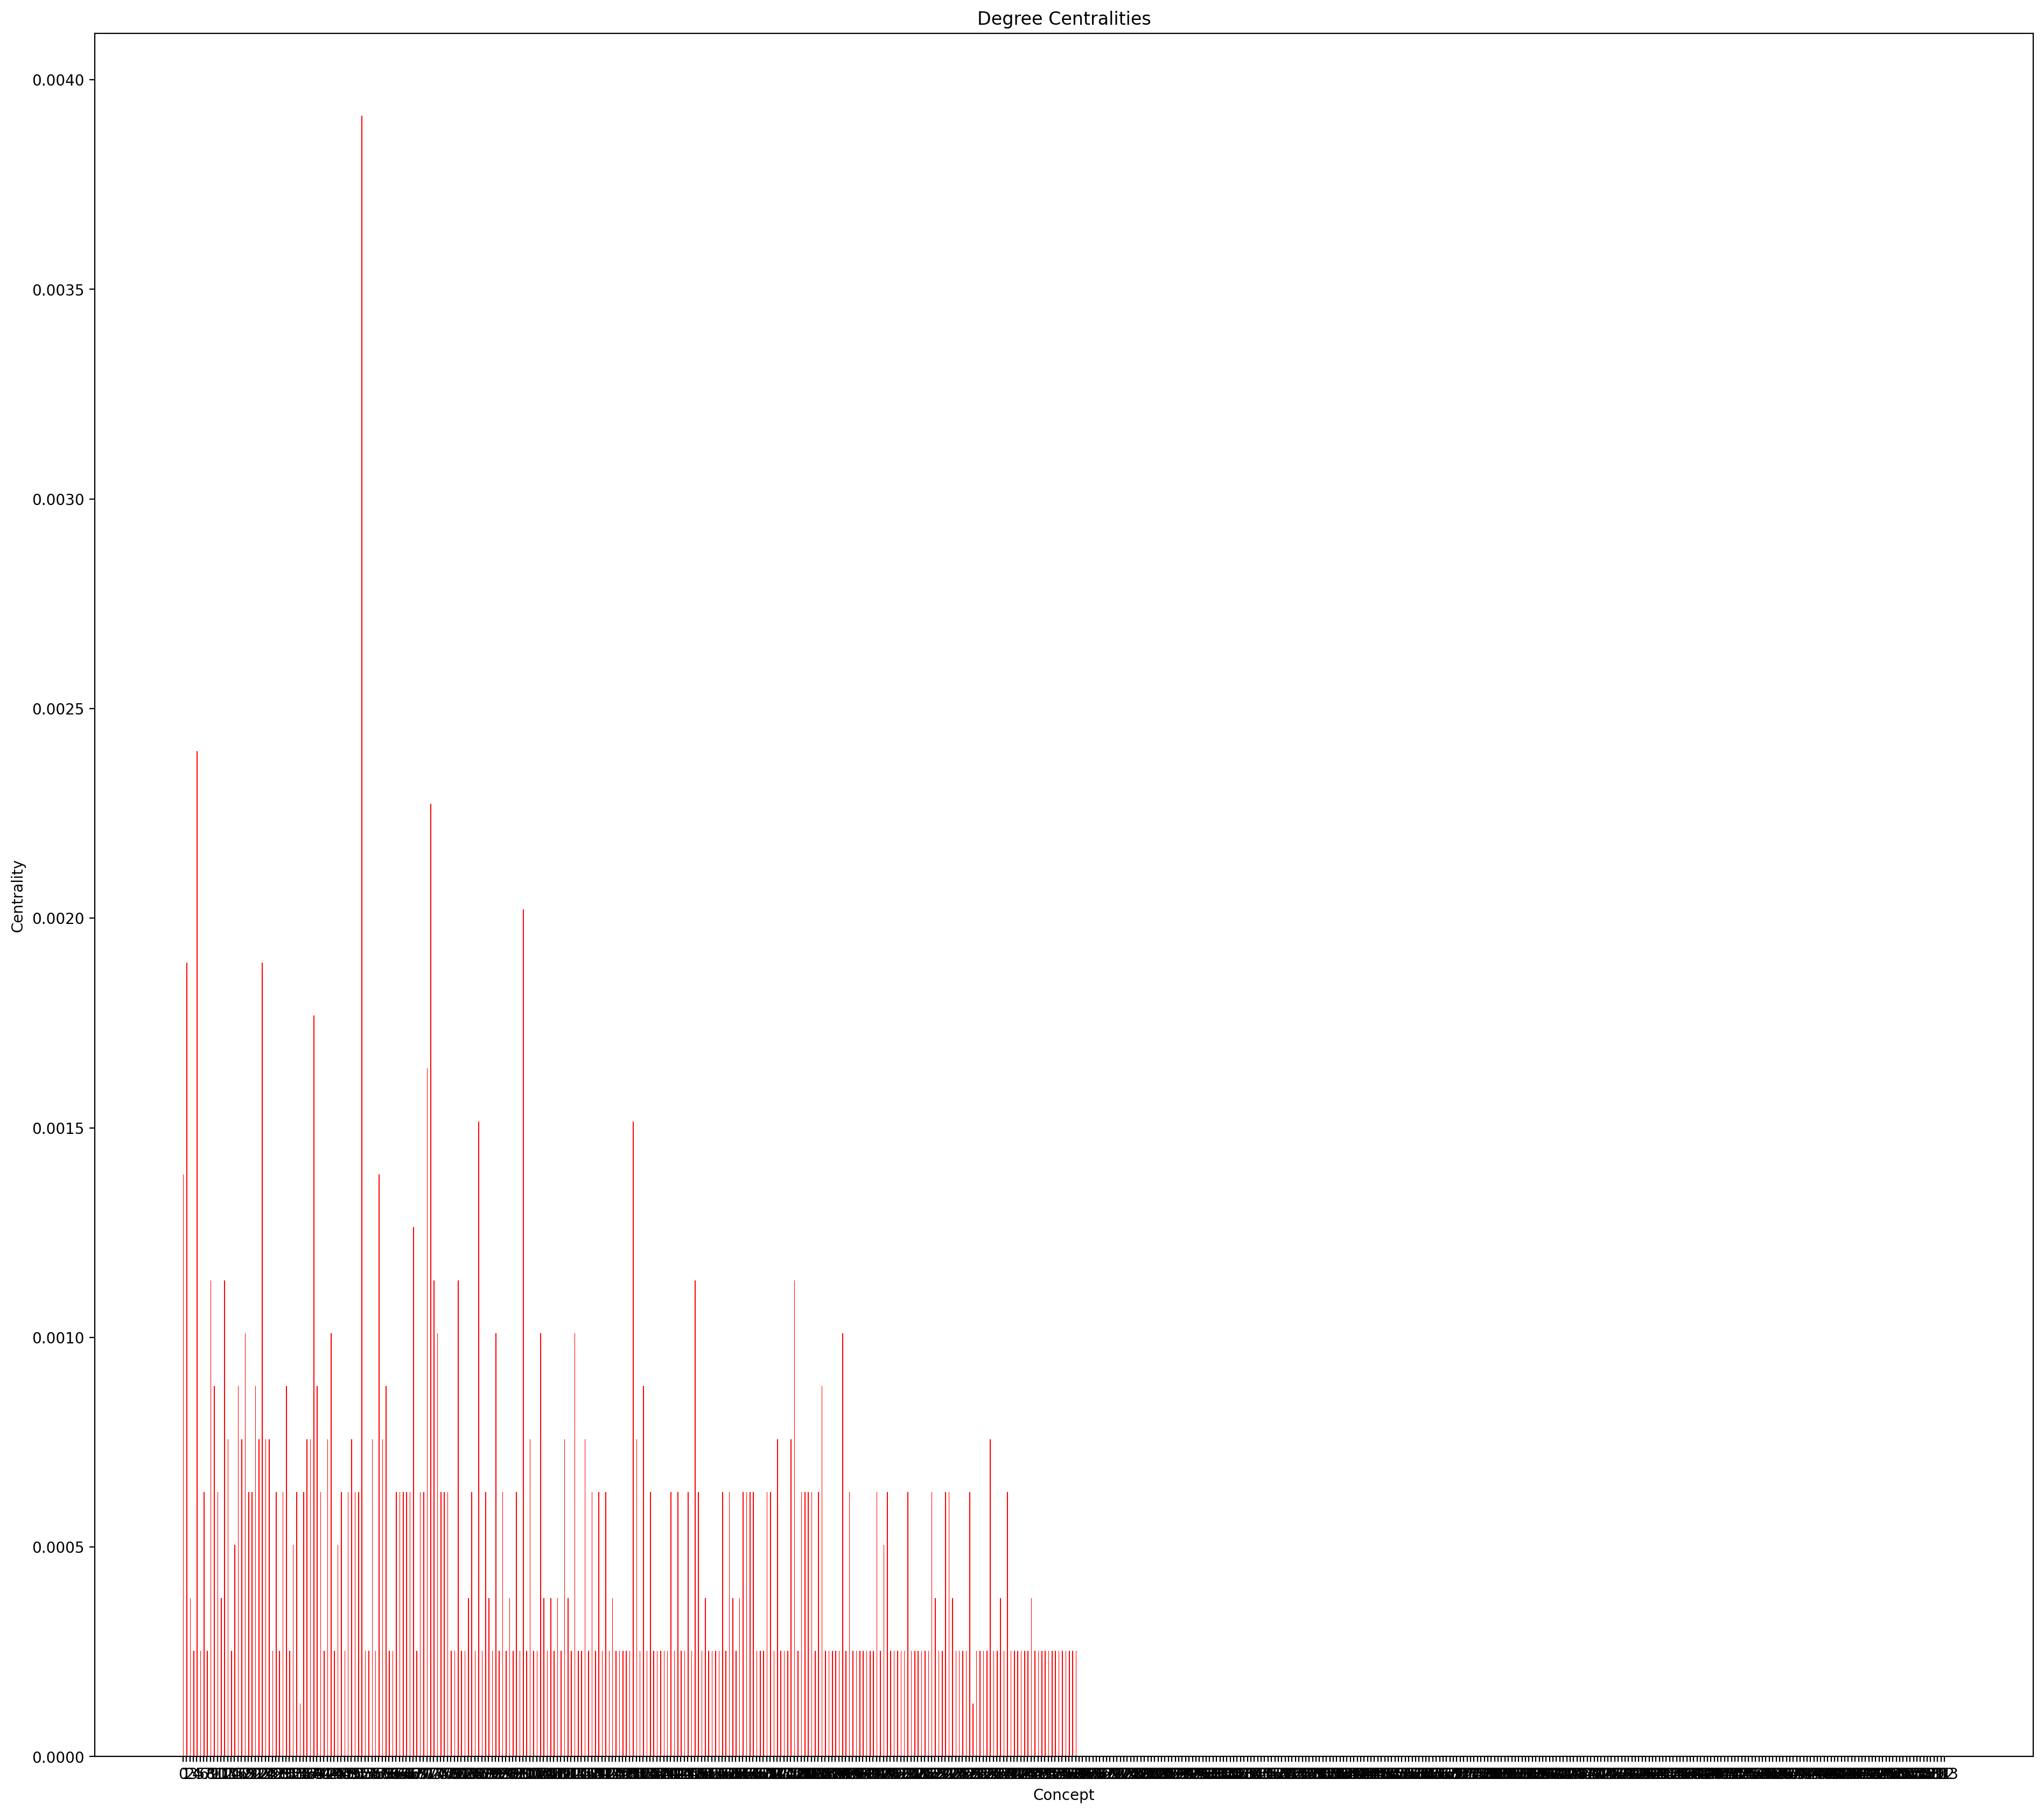

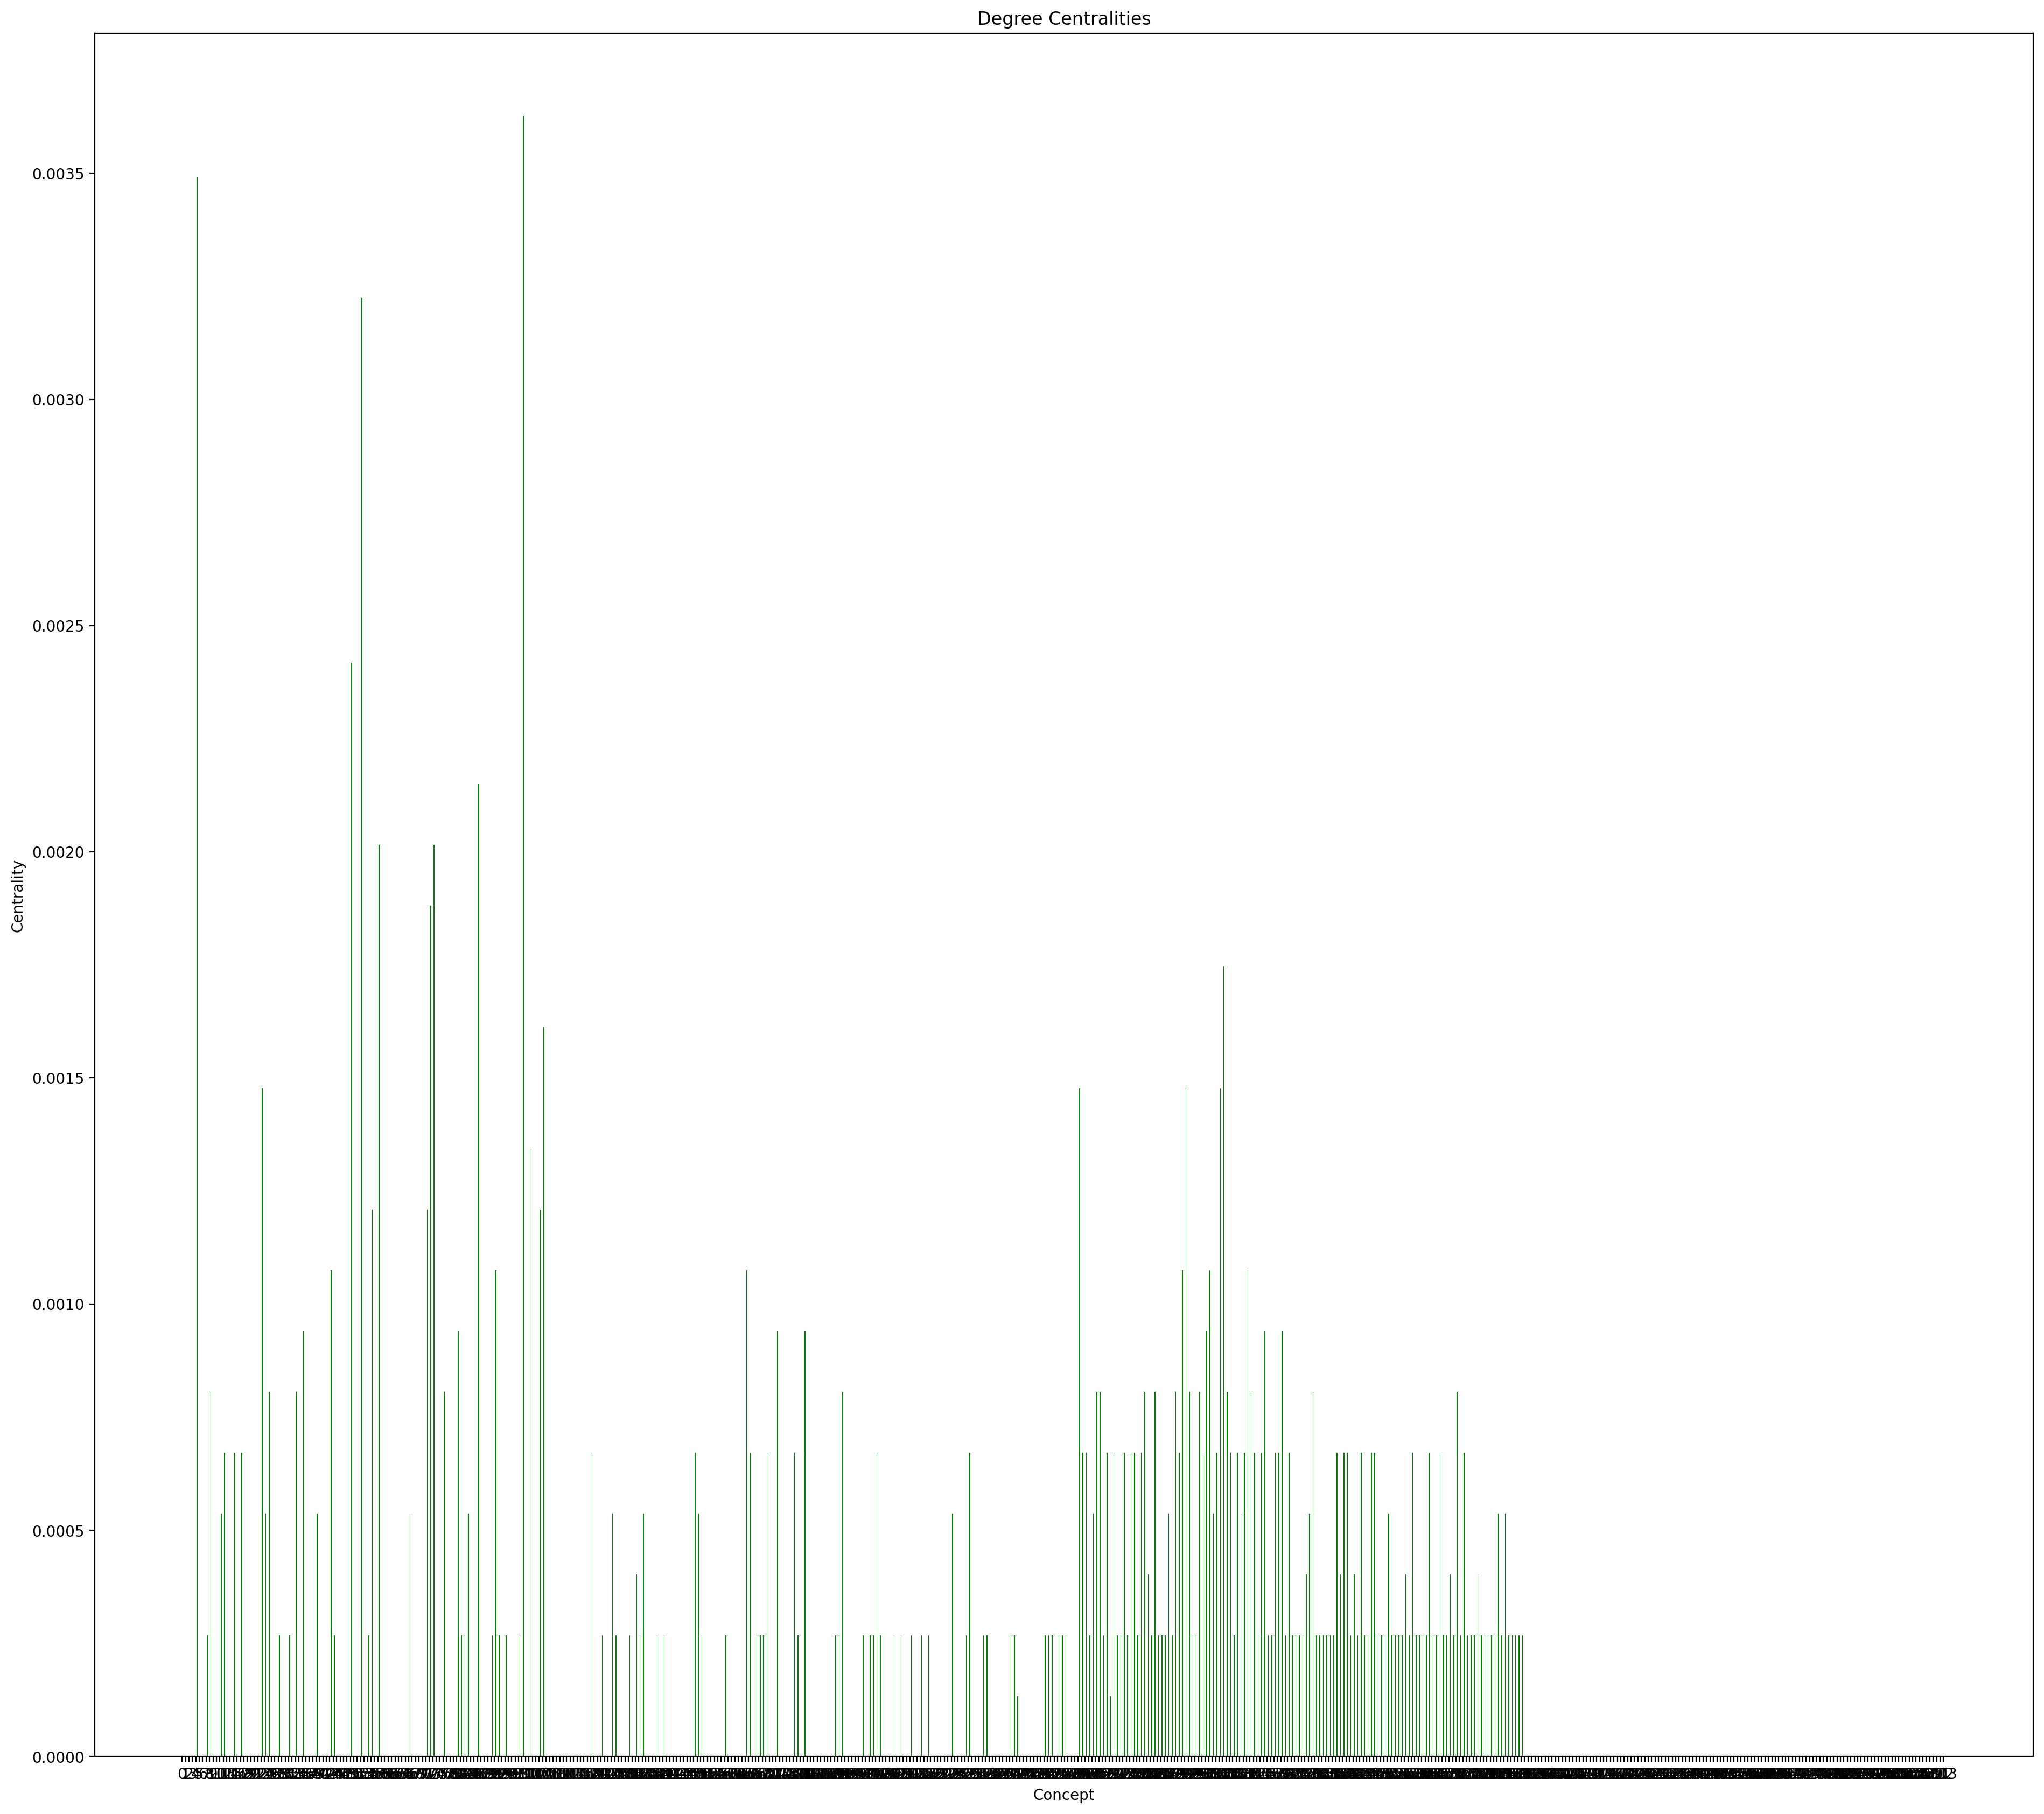

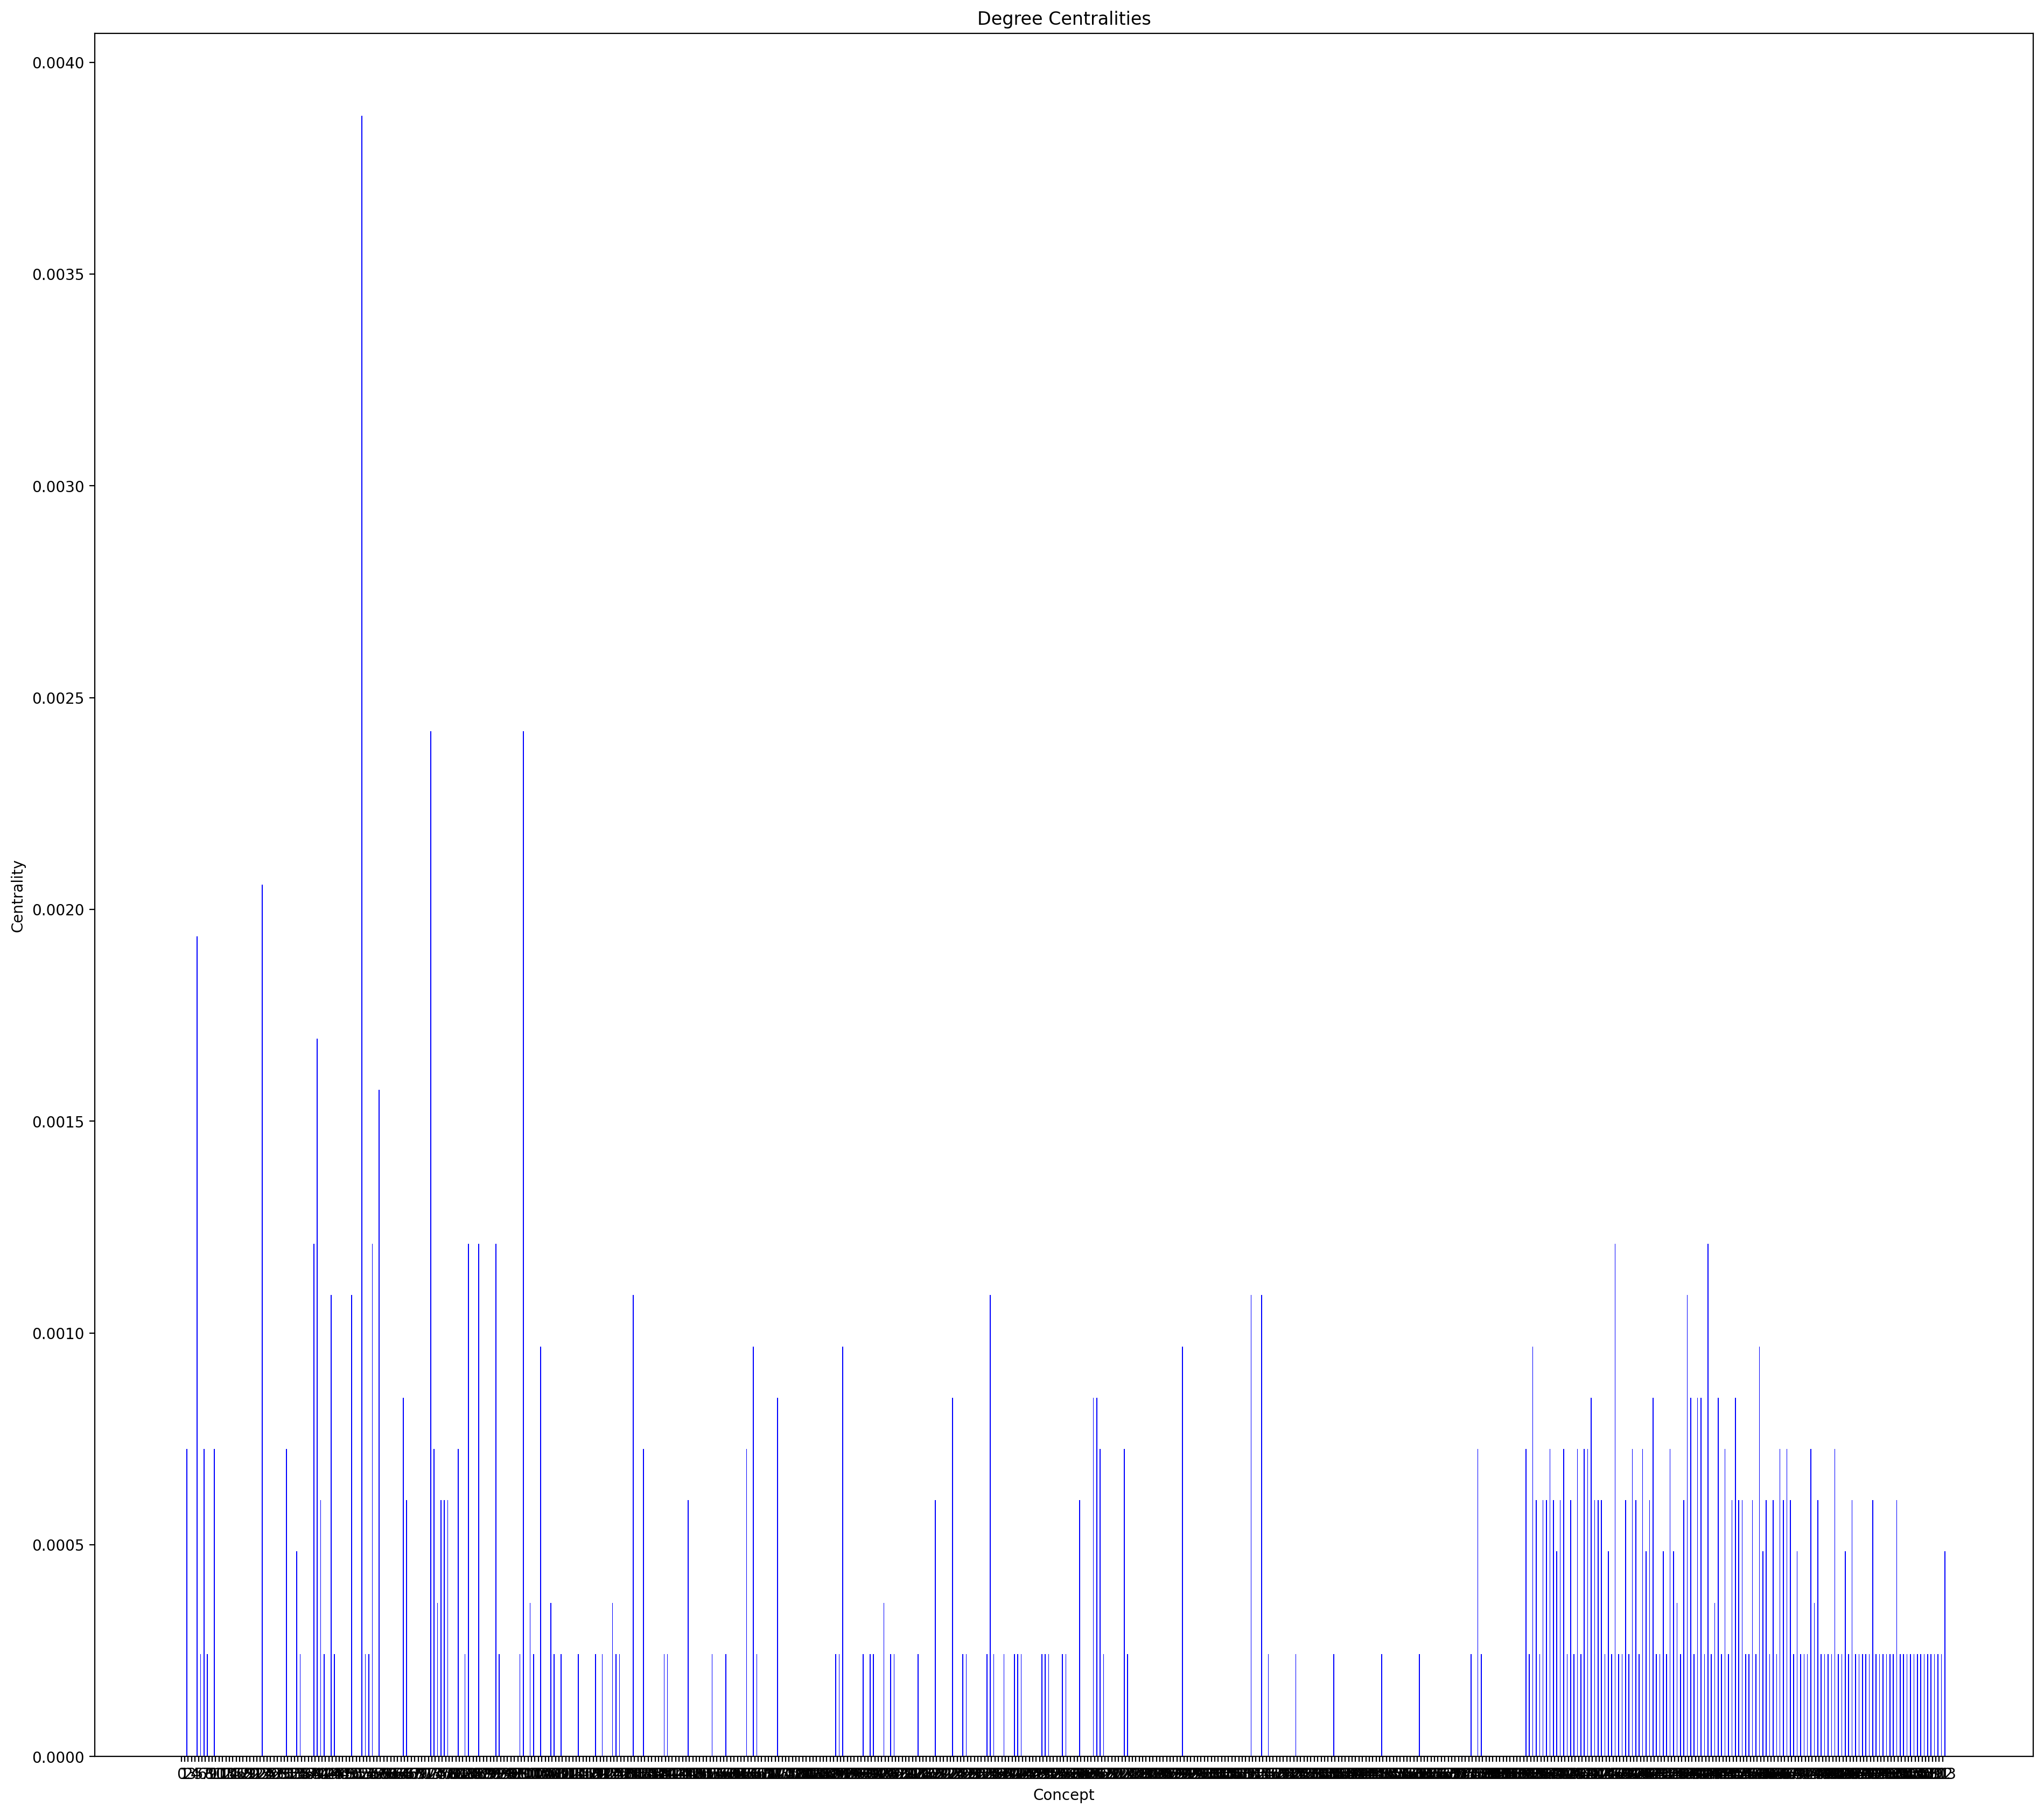

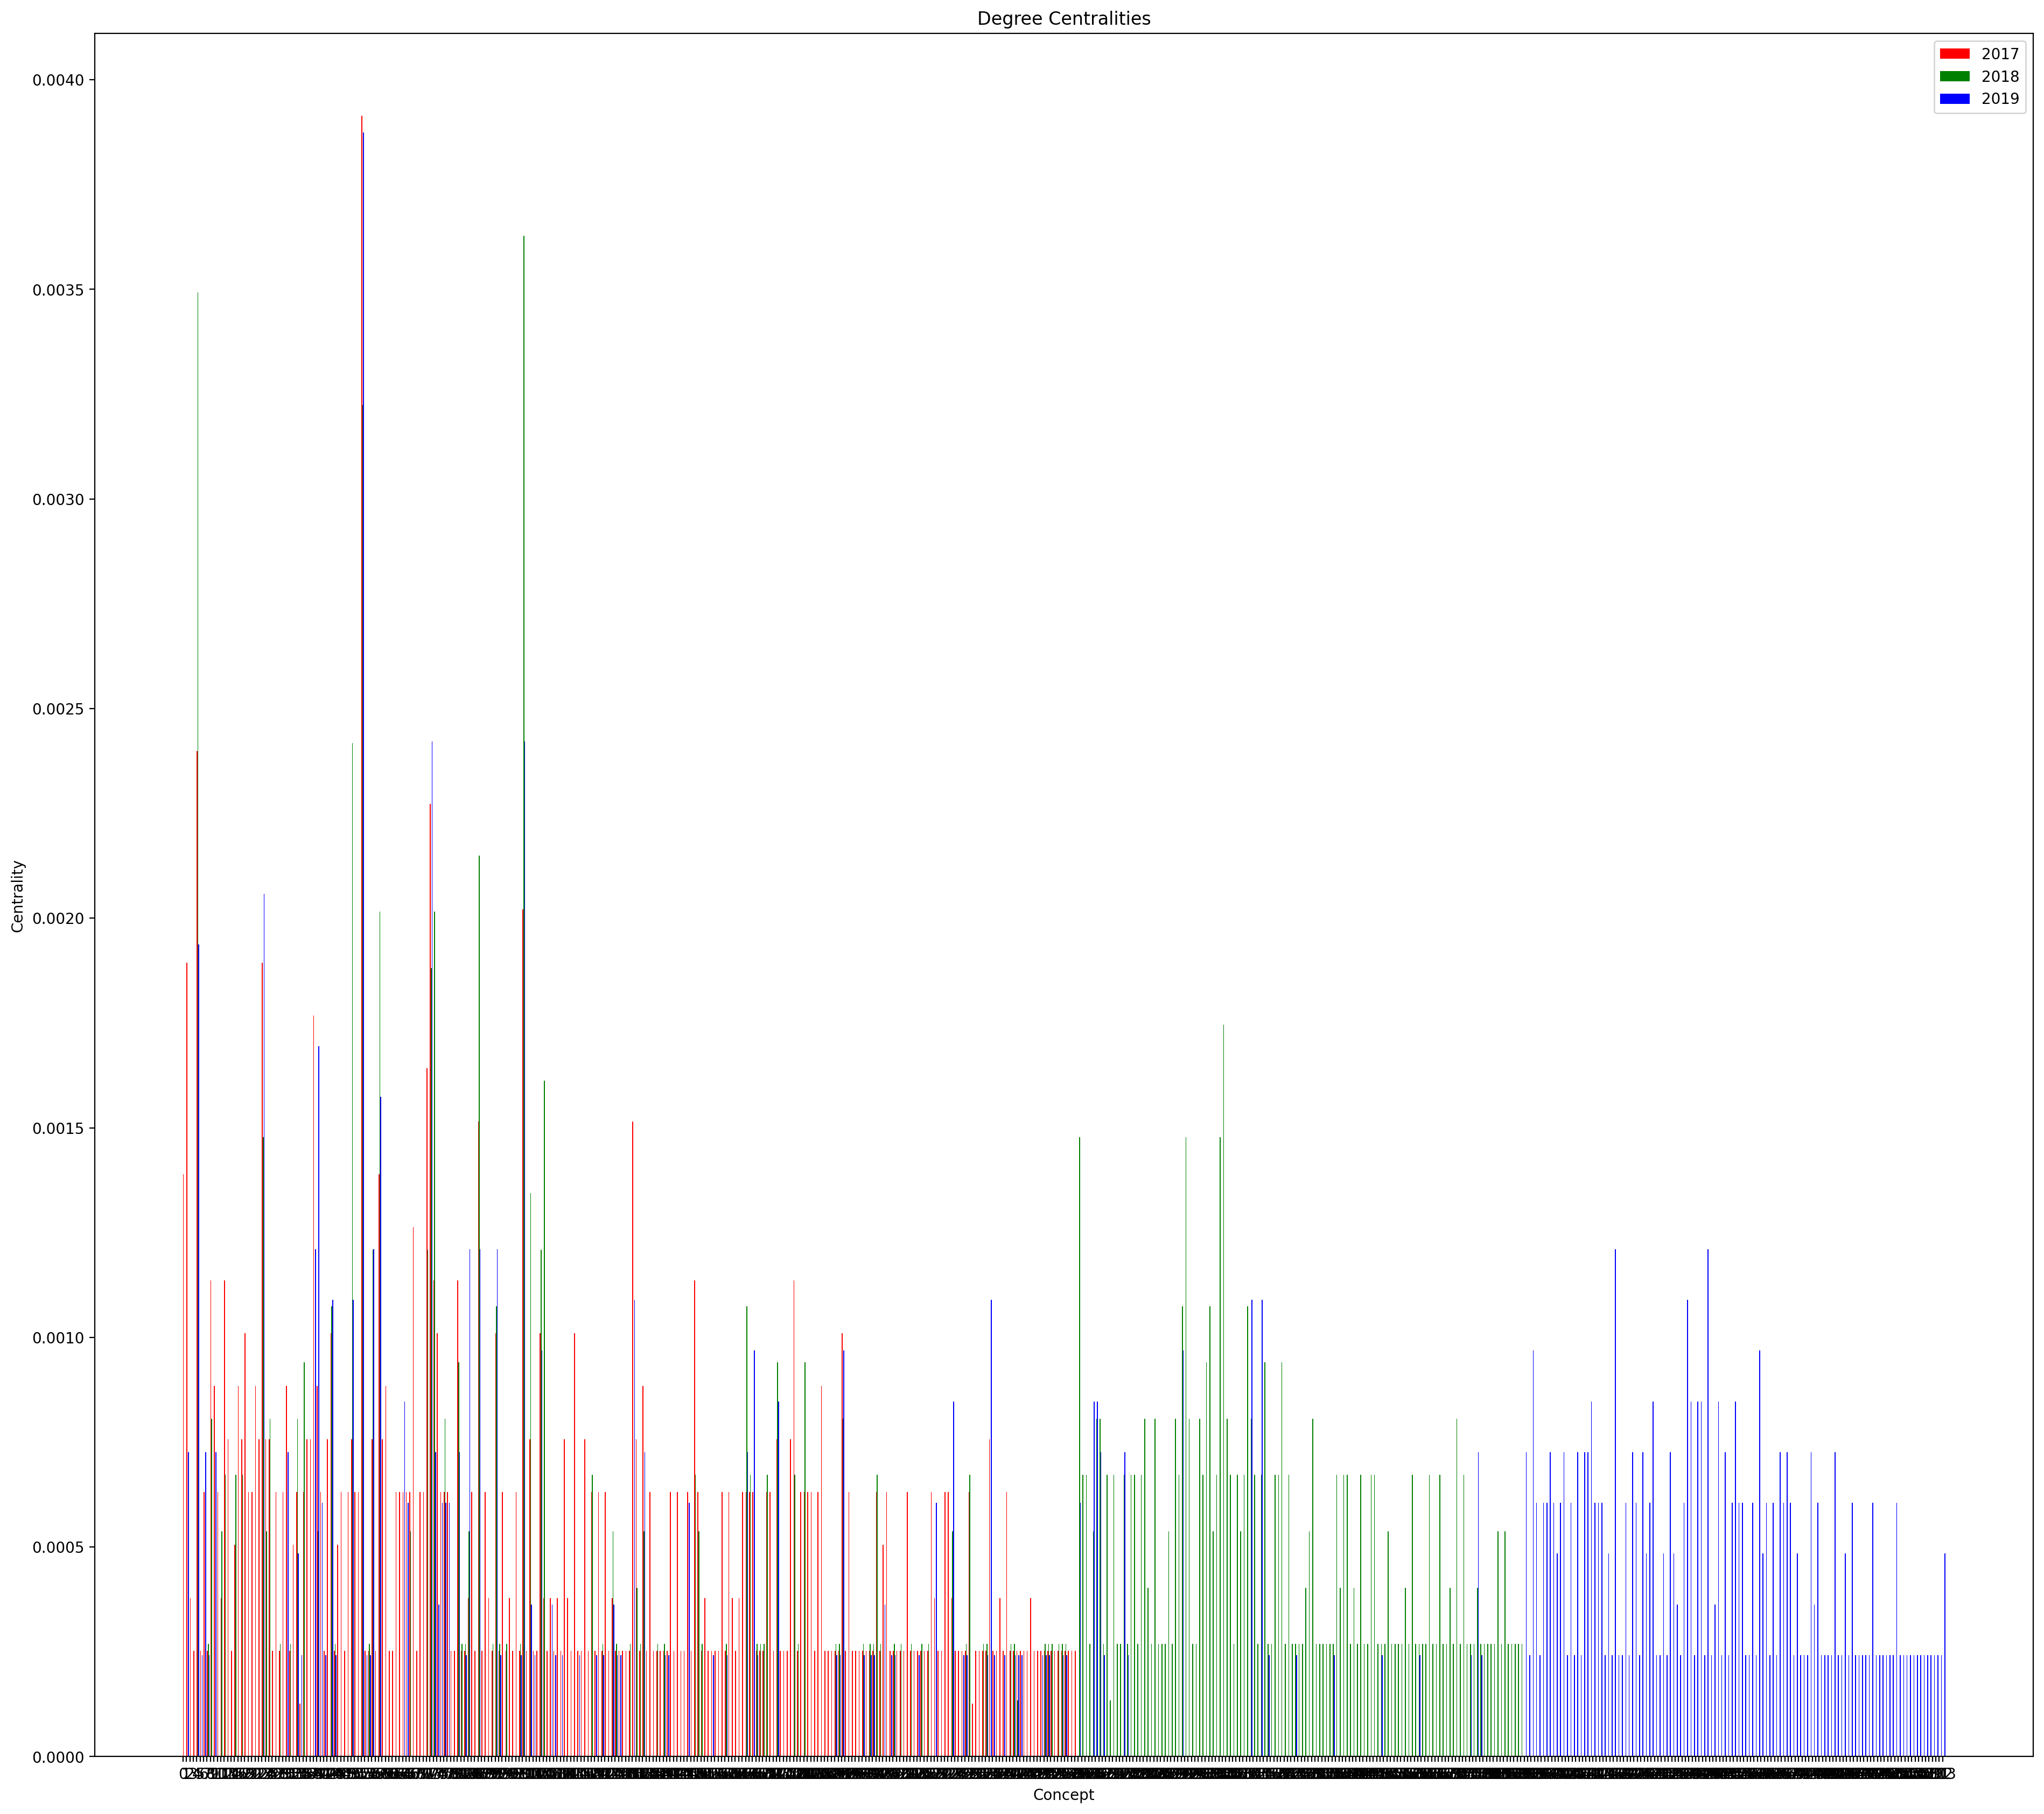

In [6]:
print('DEGREE CENTRALITY')
plot_all(deg_centrality, 'Degree Centralities')

TOP DEGREE CENTRALITIES
39
{rdflib.term.URIRef('http://local/local.owl#ontology'): [0.003914141414141414, 0.0032240730789897904, 0.00387409200968523], rdflib.term.URIRef('http://local/local.owl#sparql'): [0.002398989898989899, 0.003492745835572273, 0.001937046004842615], rdflib.term.URIRef('http://local/local.owl#ontologies'): [0.0022727272727272726, 0.0018807092960773778, 0.002421307506053269], rdflib.term.URIRef('http://local/local.owl#rdf'): [0.00202020202020202, 0.0036270822138635144, 0.002421307506053269], rdflib.term.URIRef('http://local/local.owl#semantics'): [0.001893939393939394, 0.0014777001612036541, 0.0020581113801452786], rdflib.term.URIRef('http://local/local.owl#description_logic'): [0.001893939393939394, 0, 0.0007263922518159806], rdflib.term.URIRef('http://local/local.owl#reasoning'): [0.0017676767676767678, 0, 0.0012106537530266344], rdflib.term.URIRef('http://local/local.owl#owl'): [0.0016414141414141414, 0.0012090274046211715, 0], rdflib.term.URIRef('http://local/lo

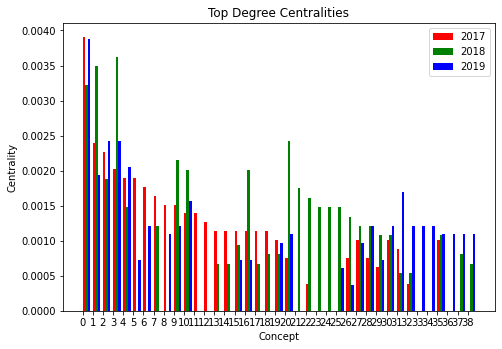

In [7]:
print('TOP DEGREE CENTRALITIES')
print(len(top_deg_centrality))
print(top_deg_centrality)
plot_combined(top_deg_centrality, 'Top Degree Centralities')

DEGREE CENTRALITY EXAMPLES
{rdflib.term.URIRef('http://local/local.owl#sparql'): [0.002398989898989899, 0.003492745835572273, 0.001937046004842615], rdflib.term.Literal('dbpedia'): [0.0002525252525252525, 0.00026867275658248256, 0.00024213075060532688], rdflib.term.URIRef('http://local/local.owl#semantics'): [0.001893939393939394, 0.0014777001612036541, 0.0020581113801452786], rdflib.term.URIRef('http://local/local.owl#natural_language_processing'): [0, 0.0014777001612036541, 0.0006053268765133172], rdflib.term.URIRef('http://local/local.owl#machine_translation'): [0.001388888888888889, 0, 0], rdflib.term.URIRef('http://local/local.owl#feature_sets'): [0, 0.0006716818914562064, 0], rdflib.term.URIRef('http://local/local.owl#web_pages'): [0, 0, 0.0007263922518159806], rdflib.term.URIRef('http://local/local.owl#ontology'): [0.003914141414141414, 0.0032240730789897904, 0.00387409200968523], rdflib.term.URIRef('http://local/local.owl#rdf'): [0.00202020202020202, 0.0036270822138635144, 0.00

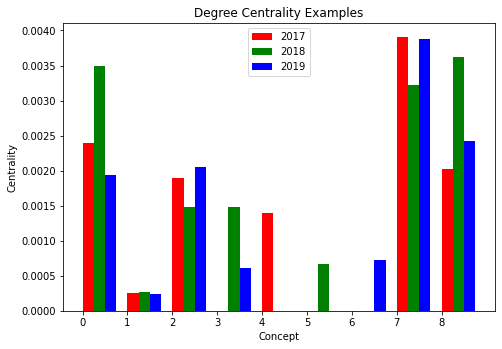

In [8]:
print('DEGREE CENTRALITY EXAMPLES')
deg_examples = get_examples(deg_centrality)
plot_combined(deg_examples, 'Degree Centrality Examples')
print(deg_examples)

In [9]:
eig_centrality, top_eig_centrality = get_centrality(nx.eigenvector_centrality)

Top 20 values for 2017
 - http://local/local.owl#rdf_data: 0.02755650190212147 -- ref:https://cso.kmi.open.ac.uk/topics/rdf_data
 - http://local/local.owl#data_mining: 0.026702616669402723 -- ref:https://cso.kmi.open.ac.uk/topics/data_mining
 - http://local/local.owl#linked_data: 0.02522667709536919 -- ref:https://cso.kmi.open.ac.uk/topics/linked_data
 - http://local/local.owl#machine_translation: 0.015052244965256586 -- ref:https://cso.kmi.open.ac.uk/topics/machine_translation
 - http://local/local.owl#machine_learning: 0.01280146166615836 -- ref:https://cso.kmi.open.ac.uk/topics/machine_learning
 - http://local/local.owl#deep_learning: 0.011351896107028246 -- ref:https://cso.kmi.open.ac.uk/topics/deep_learning
 - http://local/local.owl#servers: 0.010496740094754011 -- ref:https://cso.kmi.open.ac.uk/topics/servers
 - http://local/local.owl#query_results: 0.010258167825619714 -- ref:https://cso.kmi.open.ac.uk/topics/query_results
 - http://local/local.owl#ontologies: 0.0097738076578109

ALL EIGENVECTOR CENTRALITIES


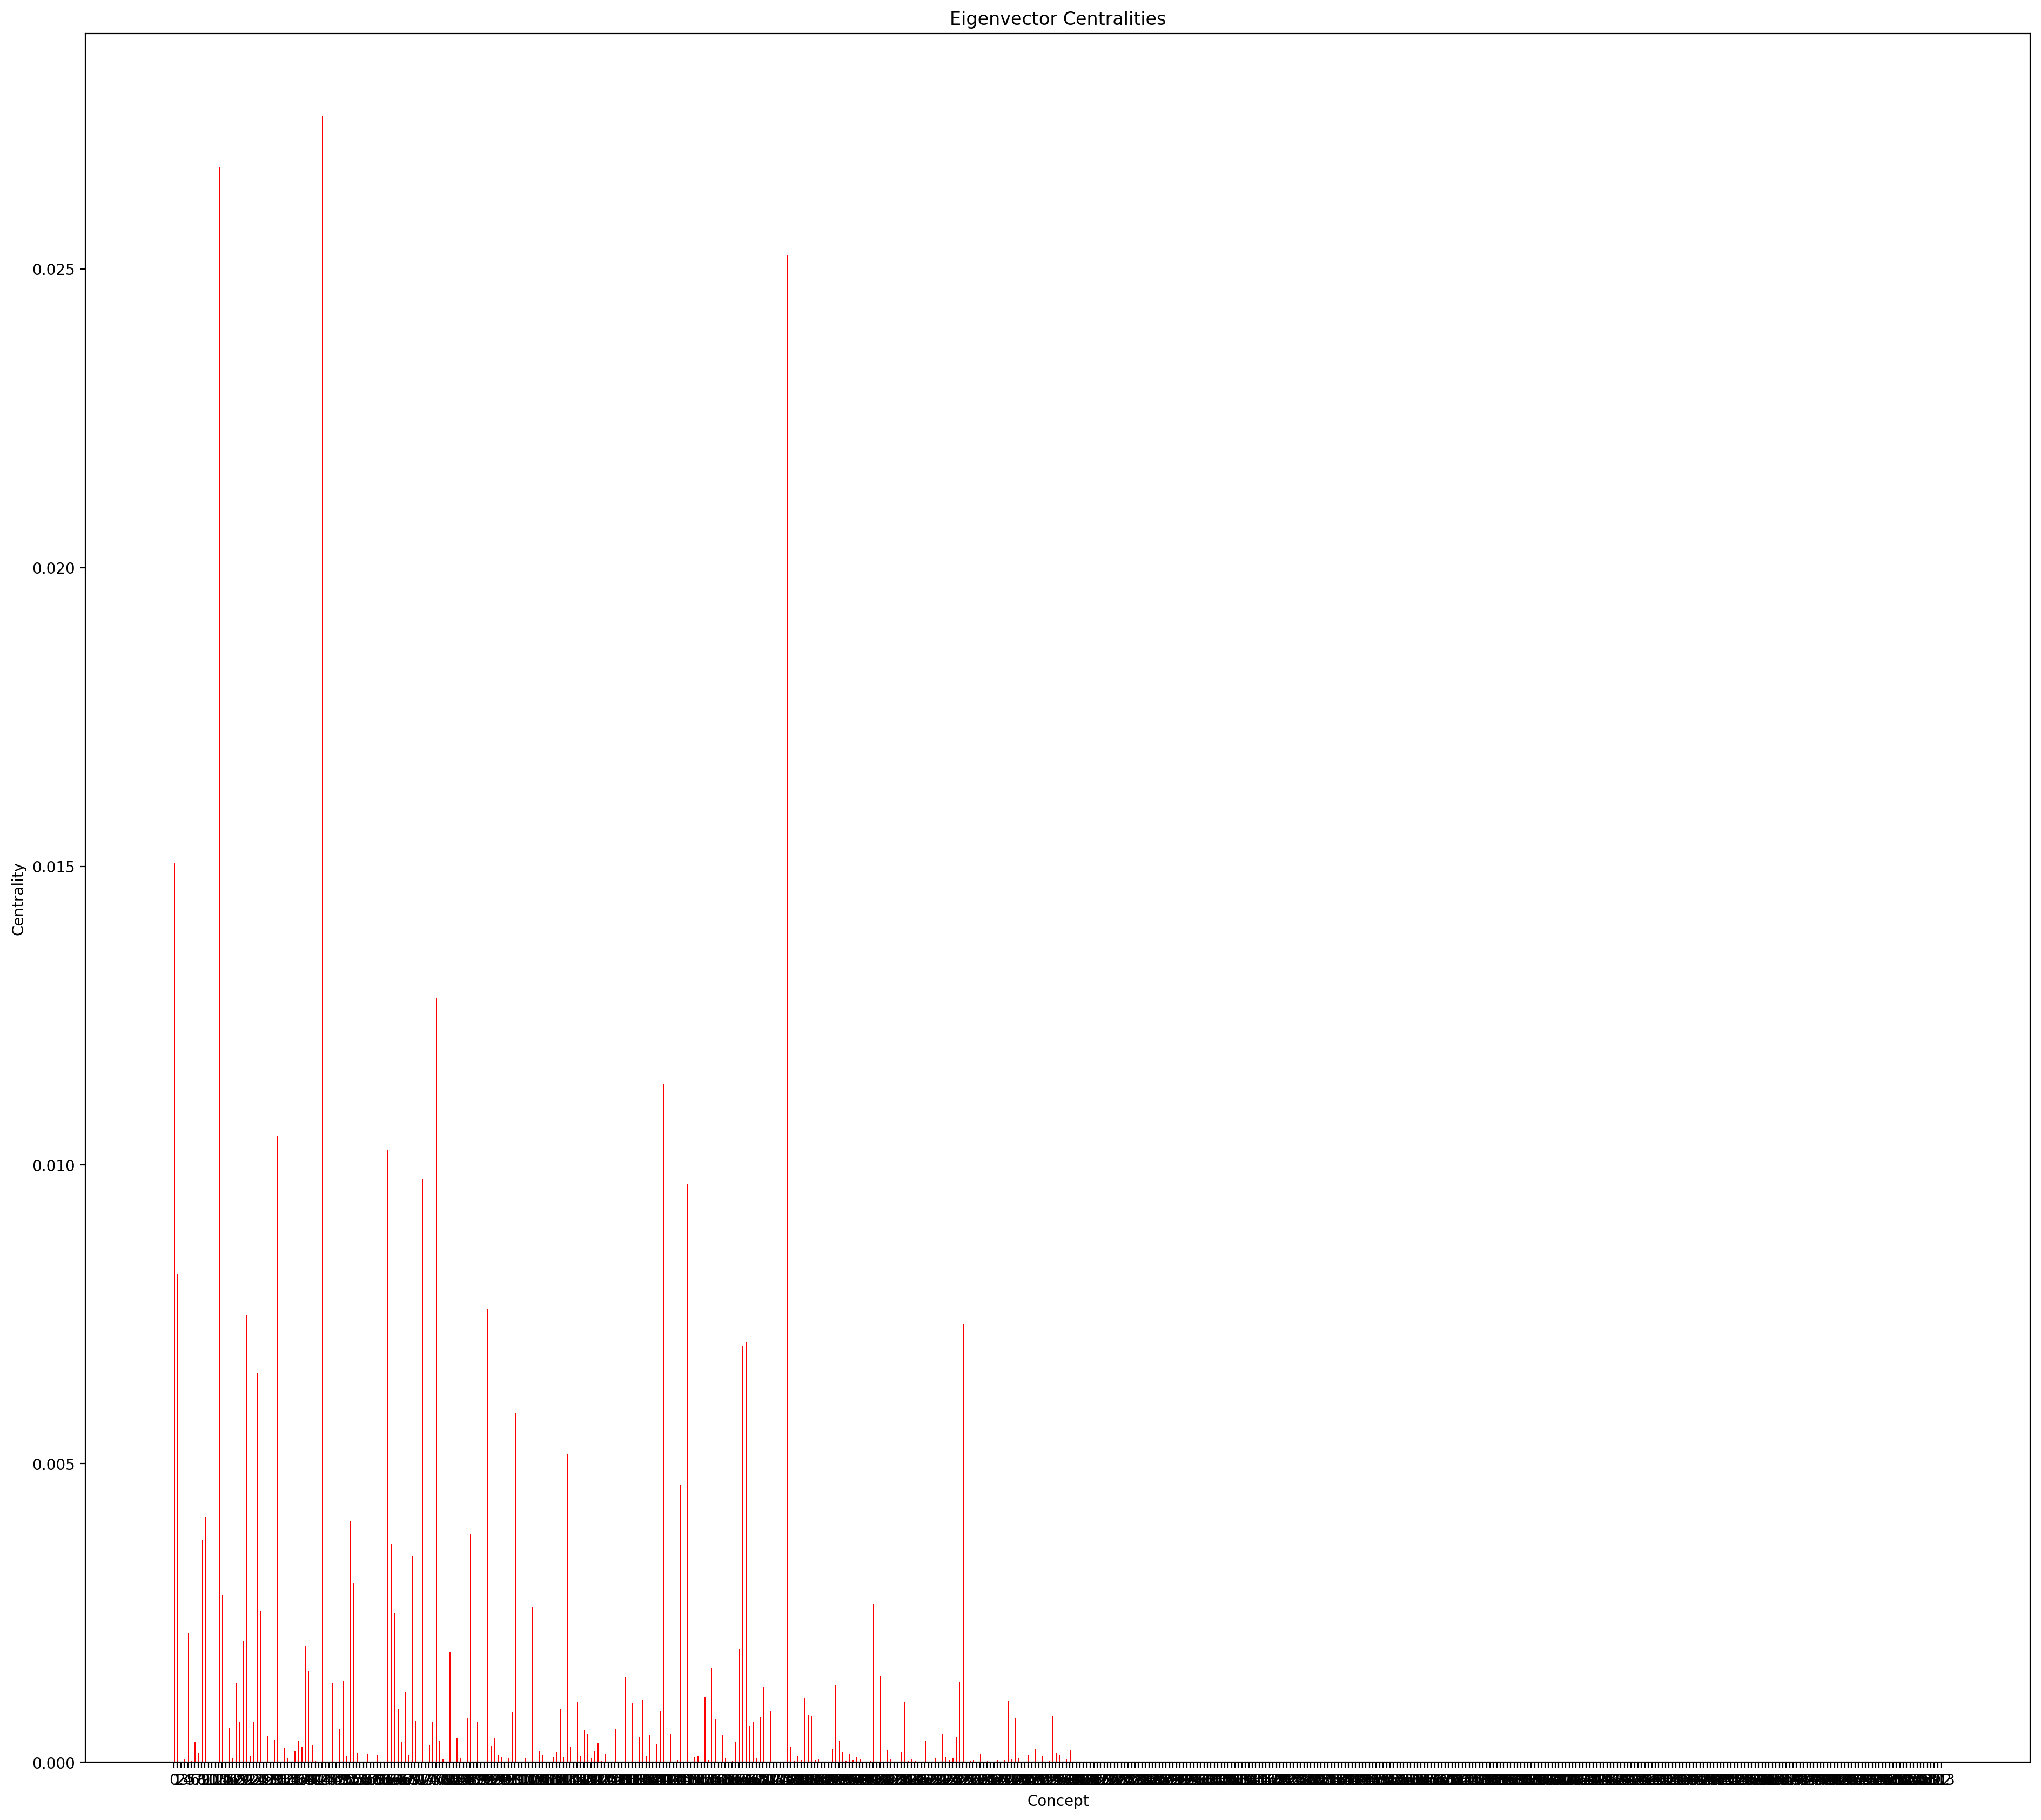

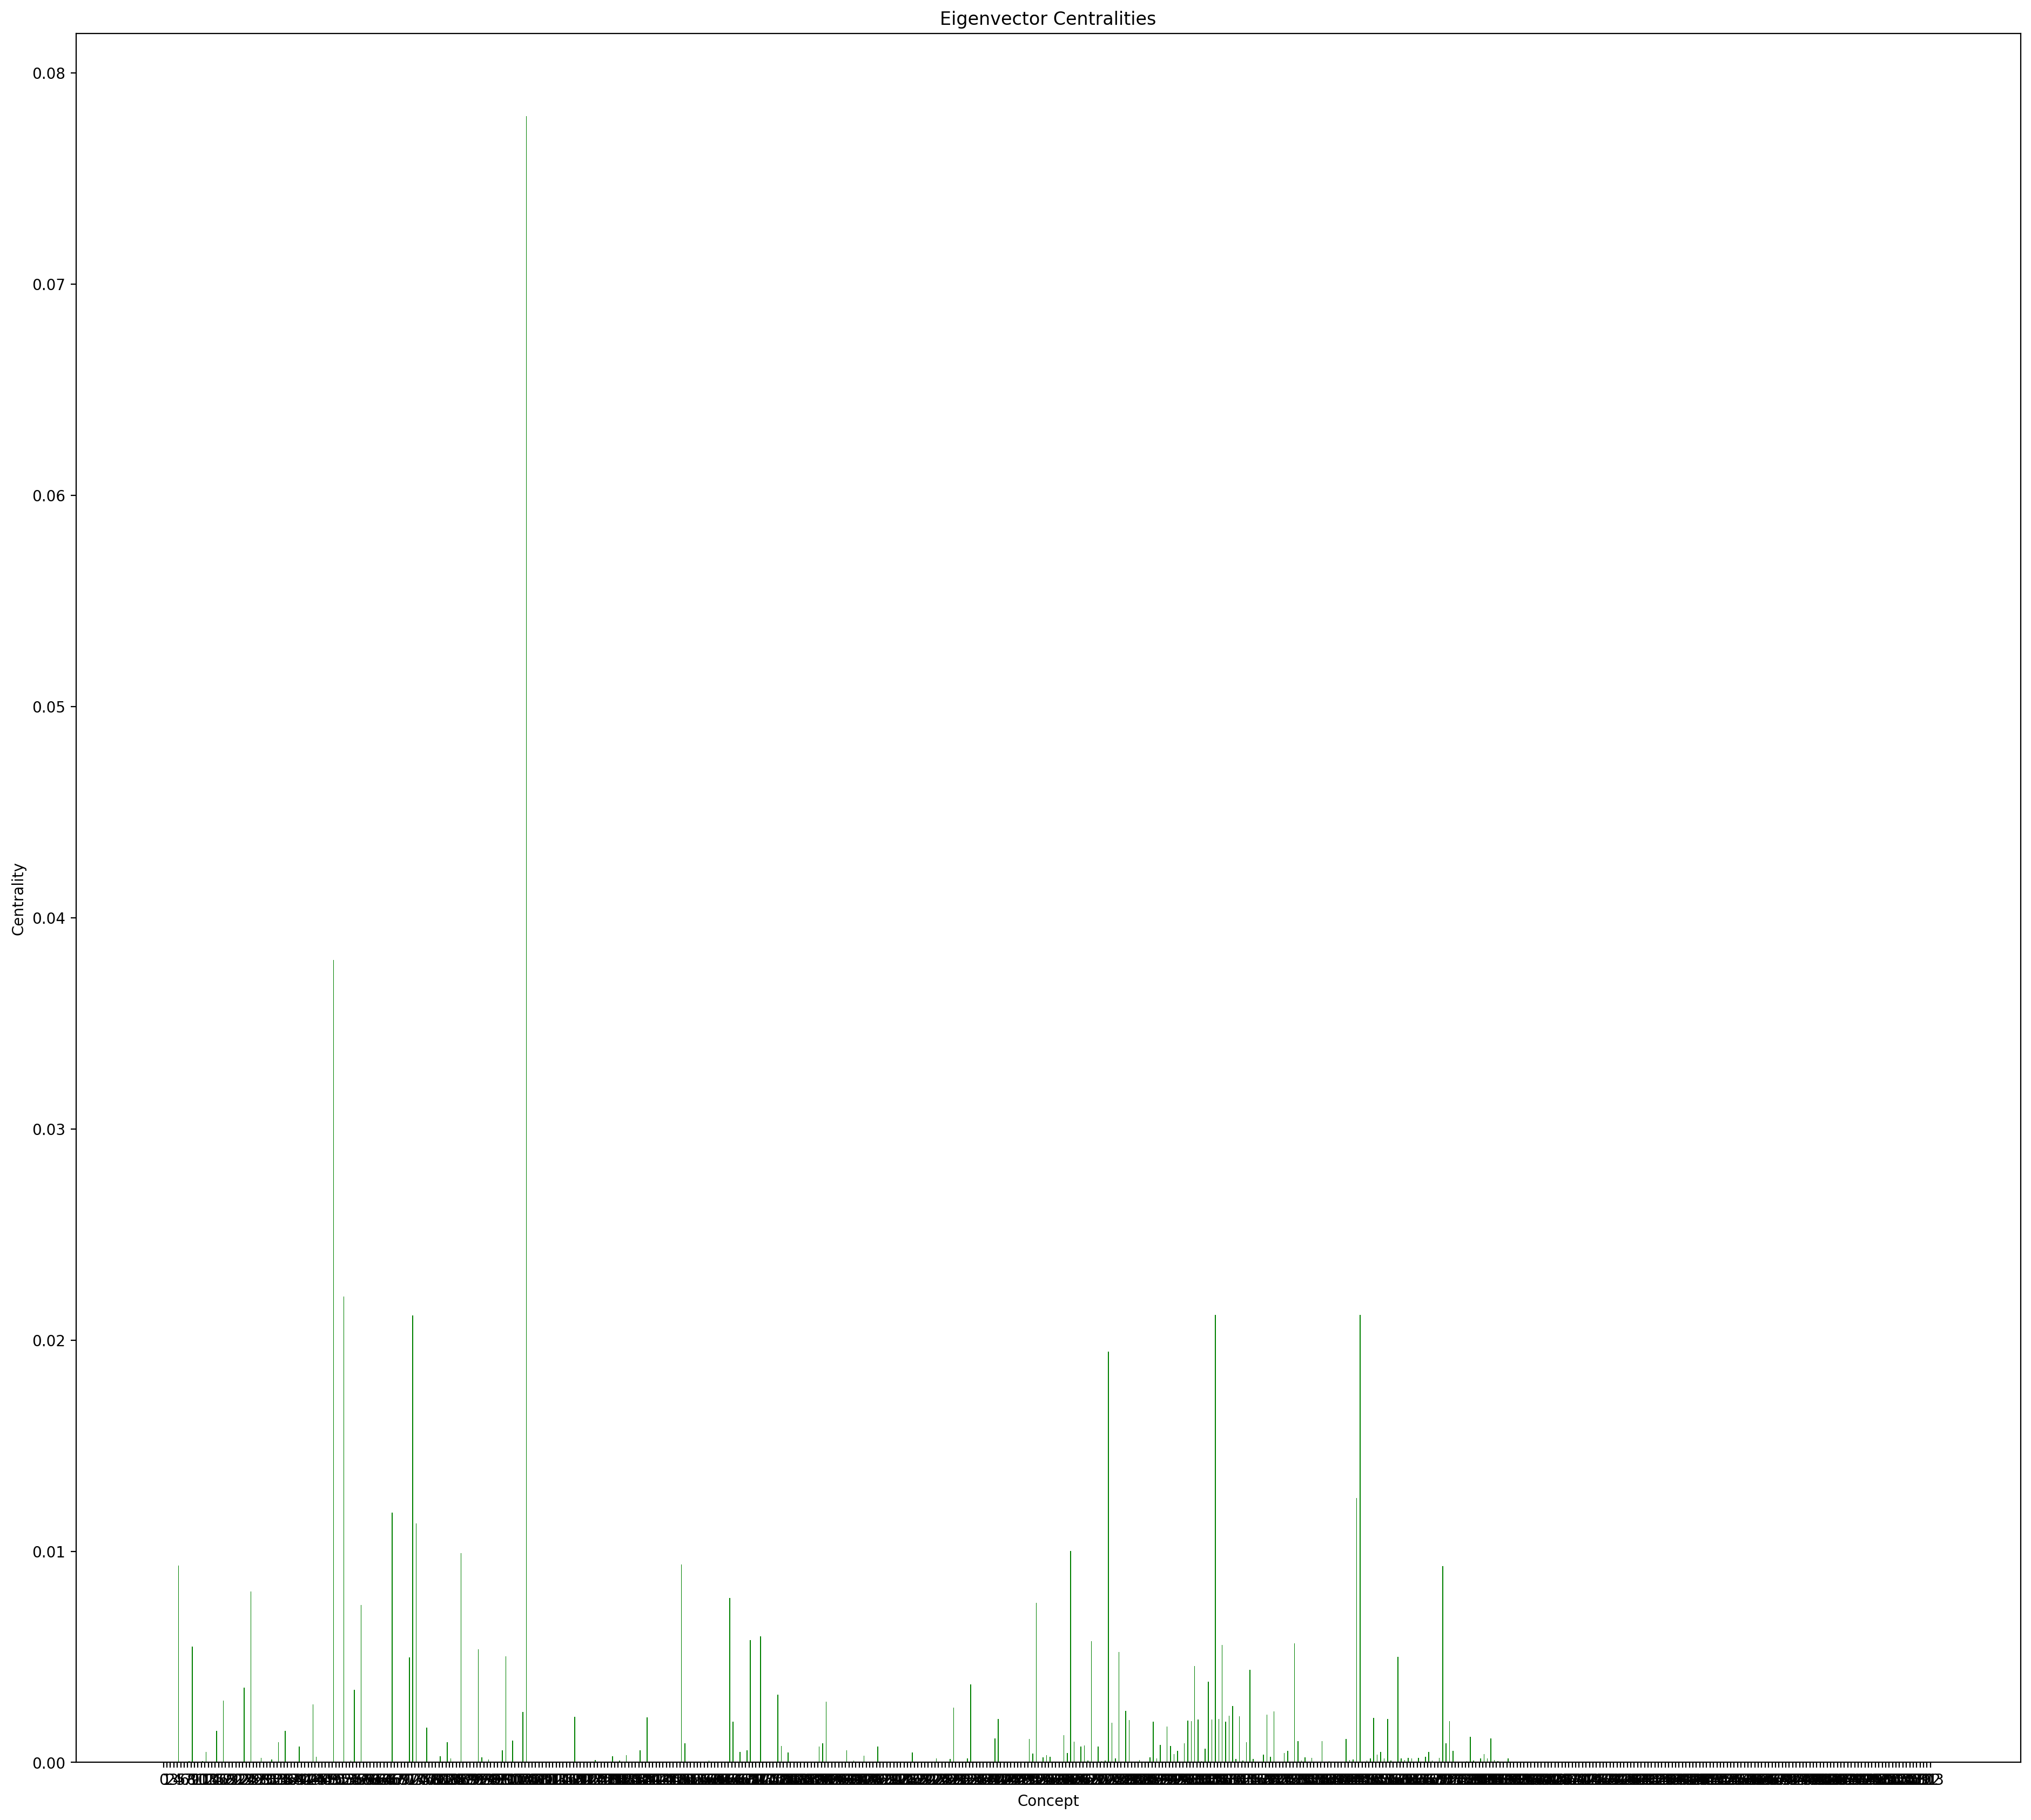

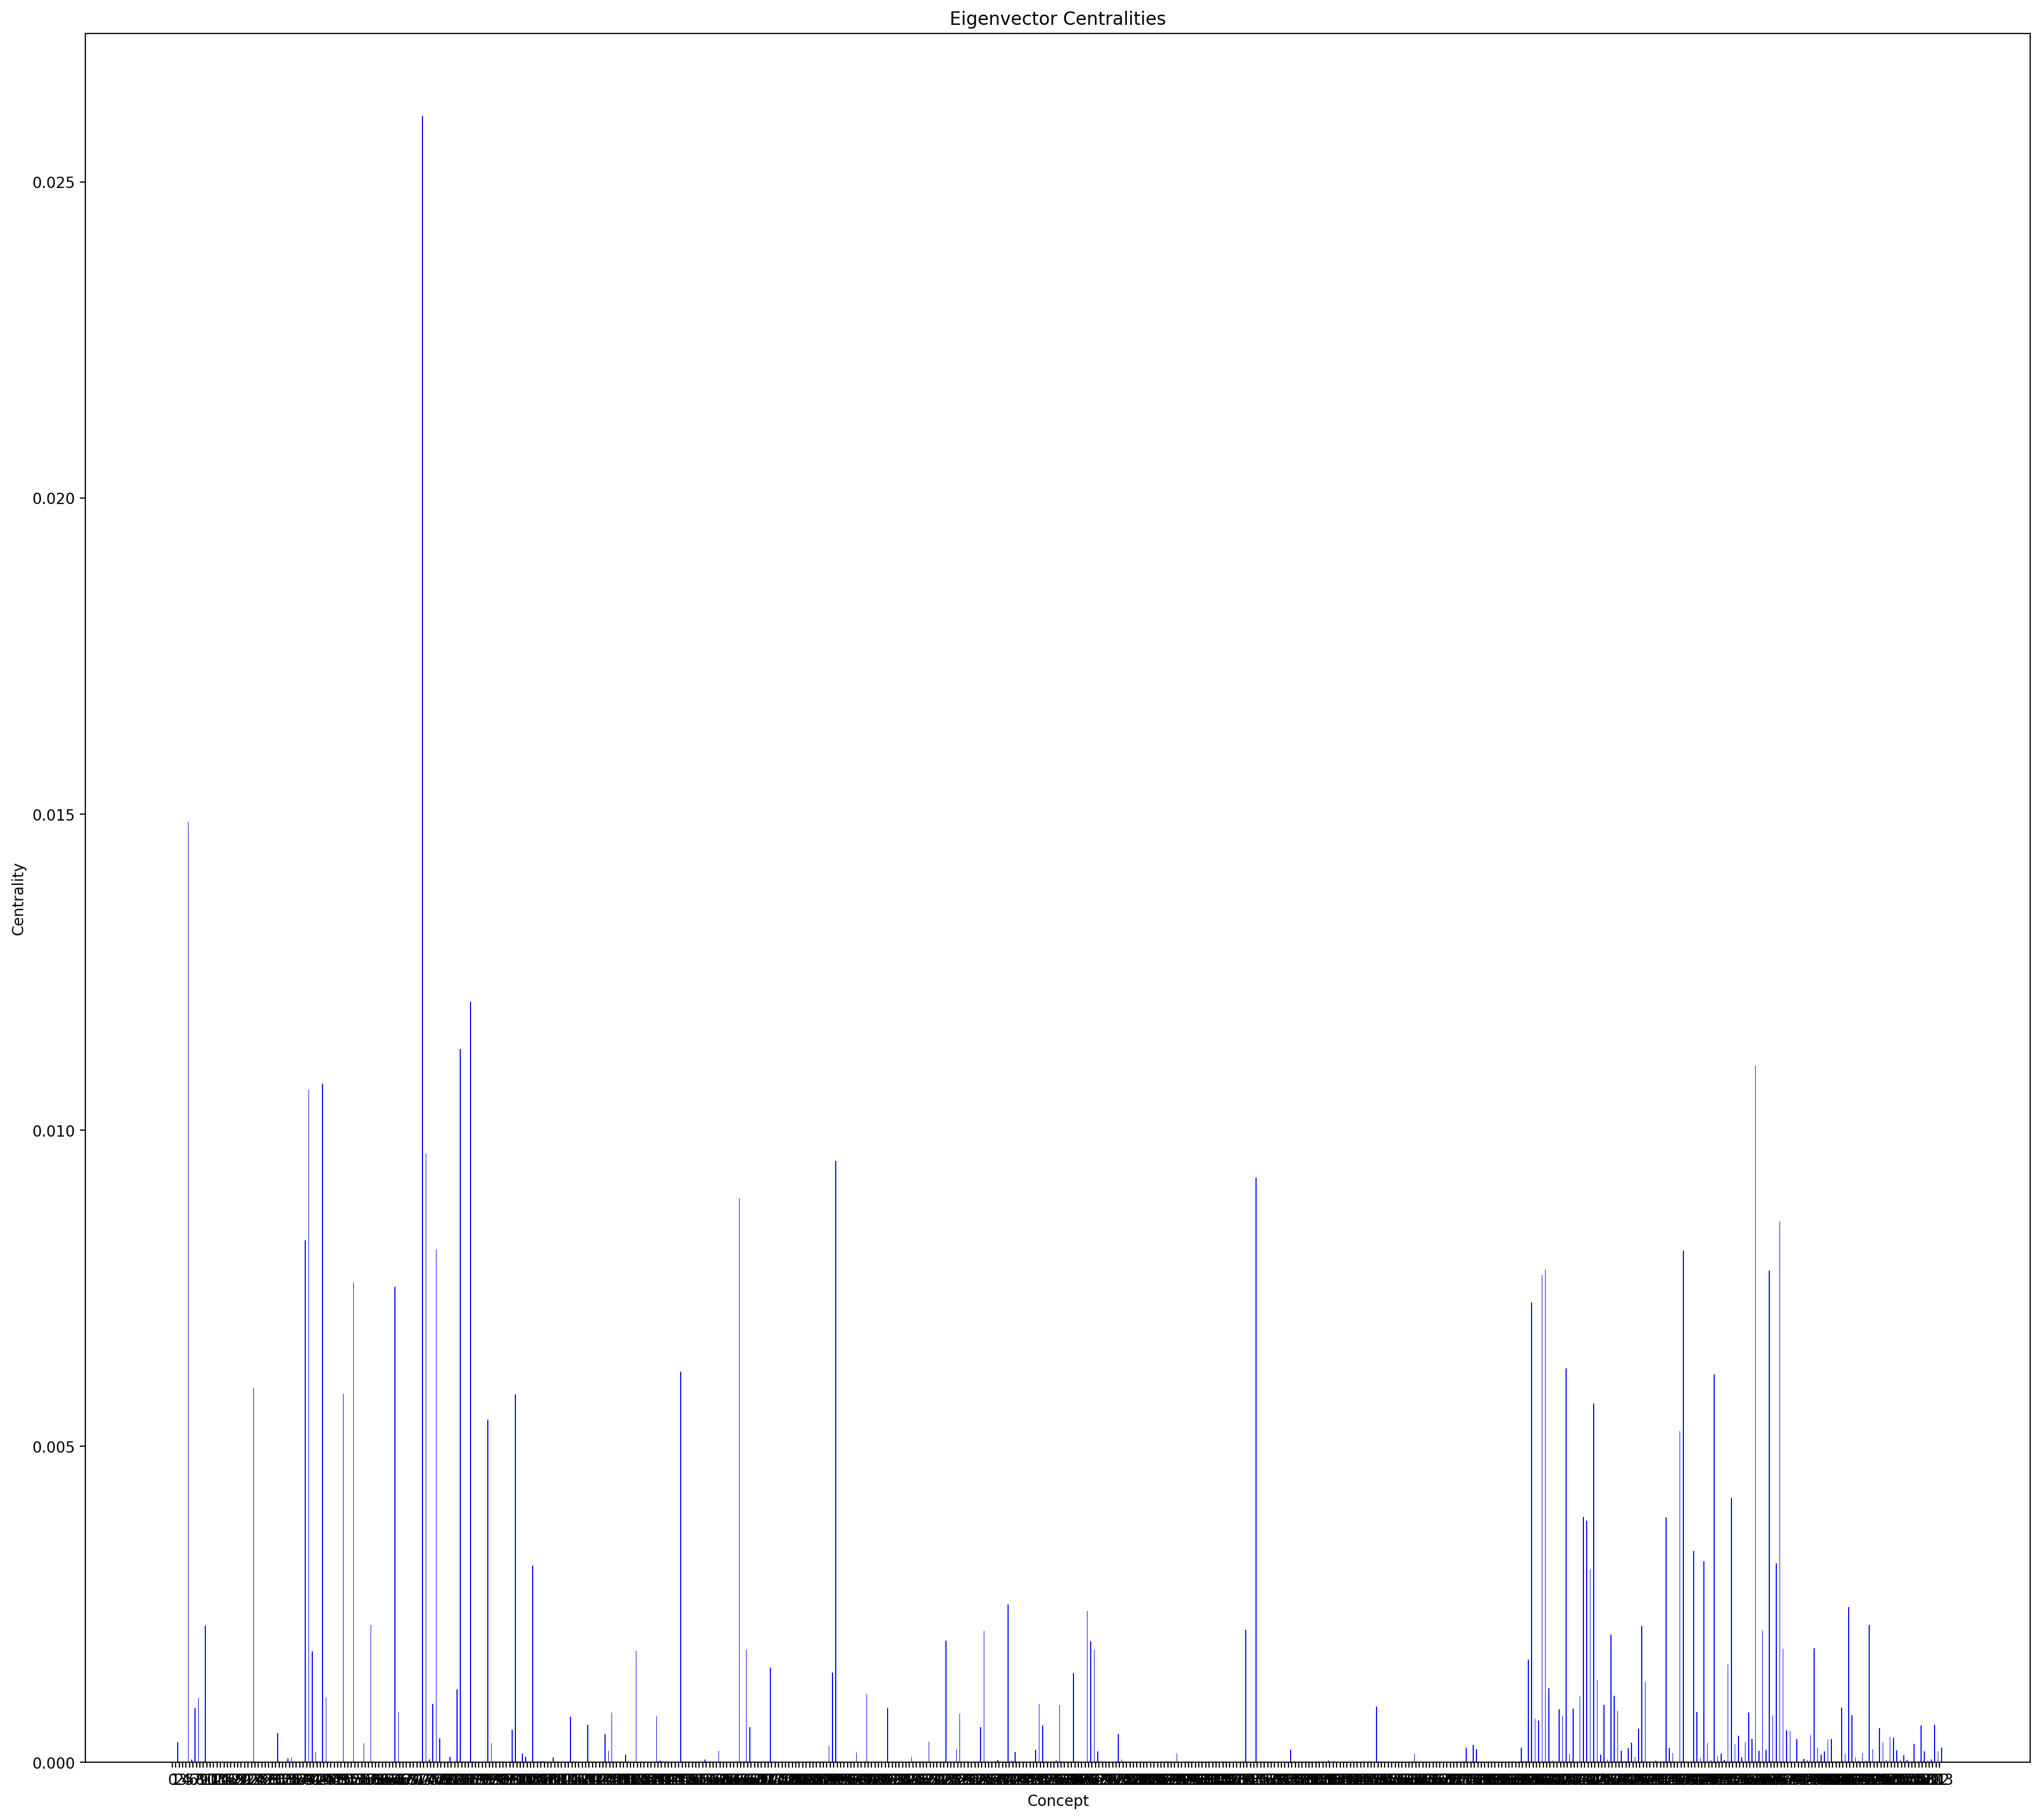

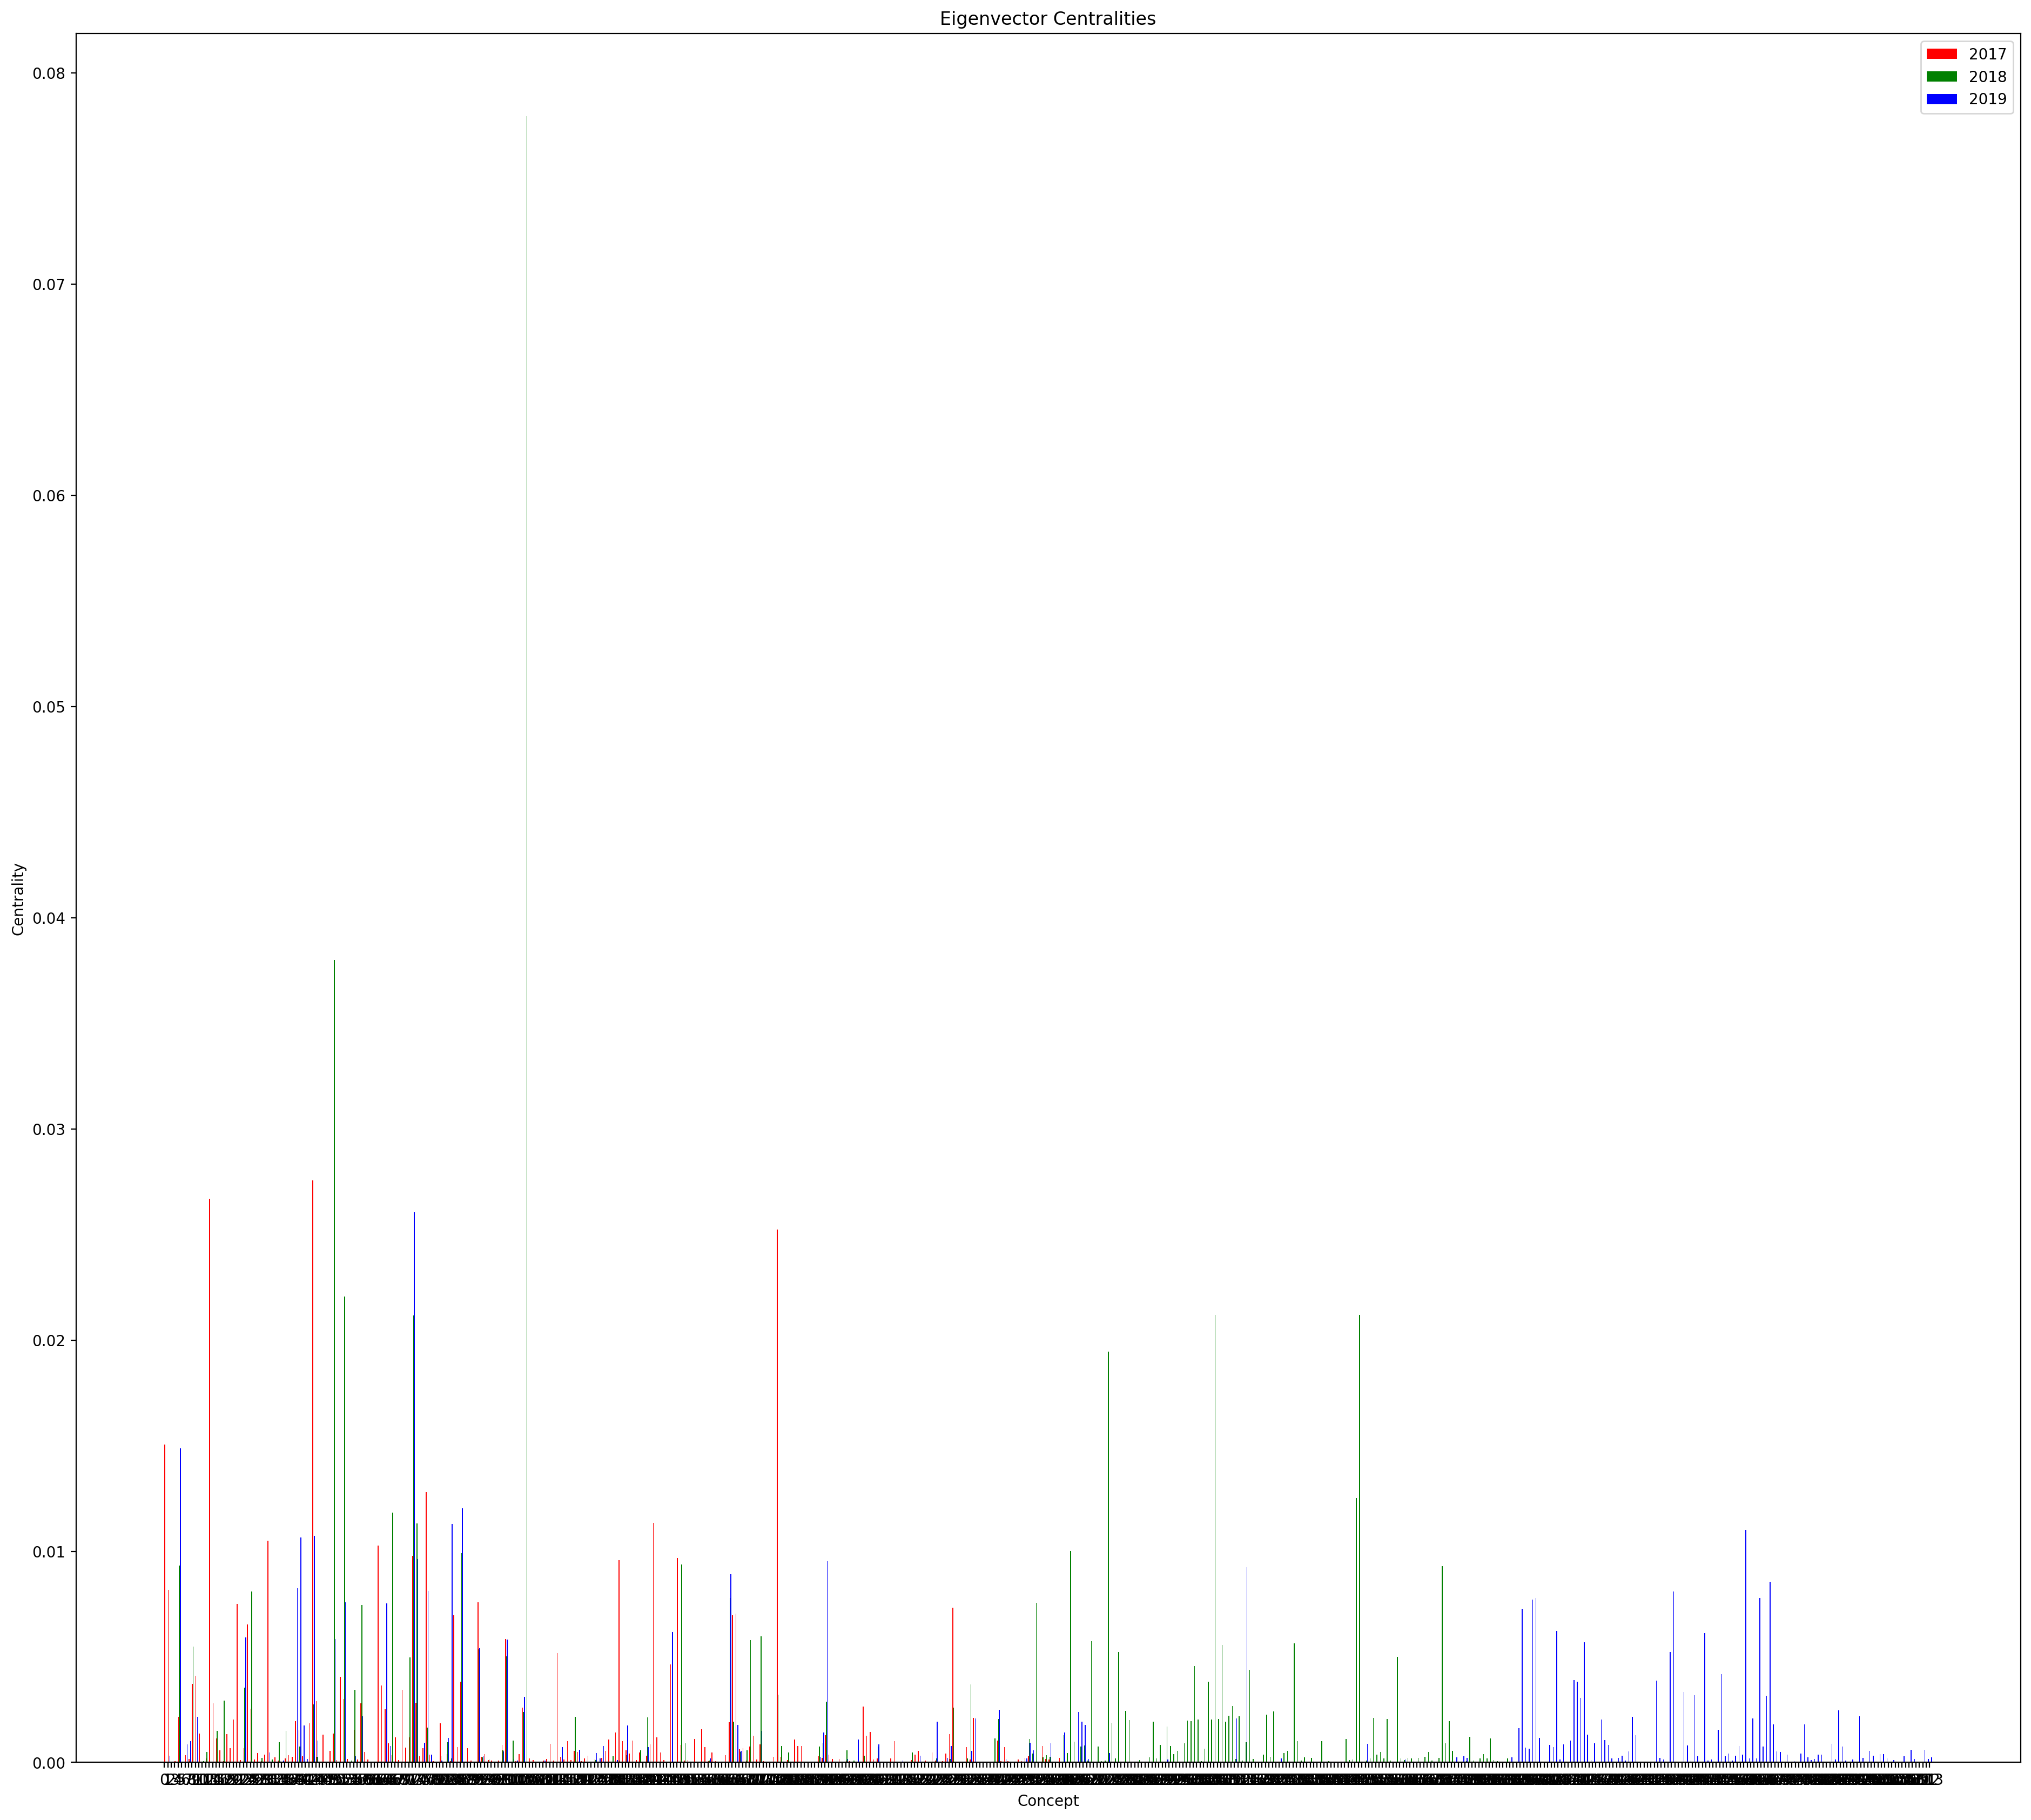

In [10]:
print('ALL EIGENVECTOR CENTRALITIES')
plot_all(eig_centrality, 'Eigenvector Centralities')

TOP EIGENVECTOR CENTRALITIES
51
{rdflib.term.URIRef('http://local/local.owl#rdf_data'): [0.02755650190212147, 0.0027433223509468942, 0.010735144291855582], rdflib.term.URIRef('http://local/local.owl#data_mining'): [0.026702616669402723, 0, 0], rdflib.term.URIRef('http://local/local.owl#linked_data'): [0.02522667709536919, 0.003212513320845767, 0], rdflib.term.URIRef('http://local/local.owl#machine_translation'): [0.015052244965256586, 0, 0], rdflib.term.URIRef('http://local/local.owl#machine_learning'): [0.01280146166615836, 0.0016532129574826624, 0.008111725260521634], rdflib.term.URIRef('http://local/local.owl#deep_learning'): [0.011351896107028246, 0, 0], rdflib.term.URIRef('http://local/local.owl#servers'): [0.010496740094754011, 0, 0.0004649831238335424], rdflib.term.URIRef('http://local/local.owl#query_results'): [0.010258167825619714, 0, 0], rdflib.term.URIRef('http://local/local.owl#ontologies'): [0.009773807657810977, 0.021171733064322486, 0.026045721232943558], rdflib.term.UR

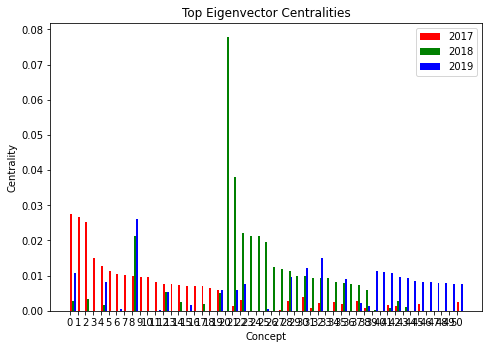

In [11]:
print('TOP EIGENVECTOR CENTRALITIES')
print(len(top_eig_centrality))
print(top_eig_centrality)
plot_combined(top_eig_centrality, 'Top Eigenvector Centralities')

EIGENVECTOR CENTRALITY EXAMPLES
{rdflib.term.URIRef('http://local/local.owl#sparql'): [0.0021710190826721575, 0.009331592791007513, 0.014885553939122258], rdflib.term.Literal('dbpedia'): [0.00015954814552081558, 7.441411043618793e-05, 0.0010197450763916658], rdflib.term.URIRef('http://local/local.owl#semantics'): [0.0006824210926033566, 0.0035324266554136704, 0.005930407522723149], rdflib.term.URIRef('http://local/local.owl#natural_language_processing'): [0, 0.0012936017665533051, 0.0014170006526652921], rdflib.term.URIRef('http://local/local.owl#machine_translation'): [0.015052244965256586, 0, 0], rdflib.term.URIRef('http://local/local.owl#feature_sets'): [0, 0.0004505793323694827, 0], rdflib.term.URIRef('http://local/local.owl#web_pages'): [0, 0, 0.00023443764556810328], rdflib.term.URIRef('http://local/local.owl#rdf_data'): [0.02755650190212147, 0.0027433223509468942, 0.010735144291855582], rdflib.term.URIRef('http://local/local.owl#caching'): [9.215348753015484e-06, 0.0779576198287

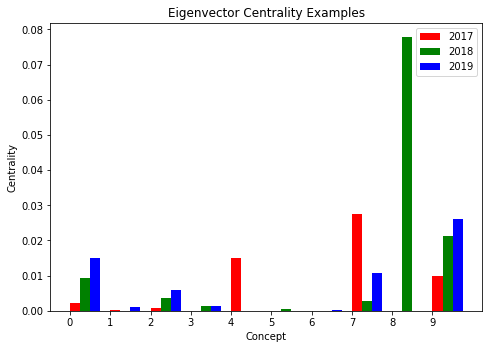

In [12]:
print('EIGENVECTOR CENTRALITY EXAMPLES')
eig_examples = get_examples(eig_centrality)
plot_combined(eig_examples, 'Eigenvector Centrality Examples')
print(eig_examples)

In [13]:
bet_centrality, top_bet_centrality = get_centrality(nx.betweenness_centrality)

Top 20 values for 2017
 - http://local/local.owl#ontology: 0.02528797196176485 -- ref:https://cso.kmi.open.ac.uk/topics/ontology
 - http://local/local.owl#ontologies: 0.014802080404017488 -- ref:https://cso.kmi.open.ac.uk/topics/ontologies
 - http://local/local.owl#description_logic: 0.011670862738332543 -- ref:https://cso.kmi.open.ac.uk/topics/description_logic
 - http://local/local.owl#sparql: 0.011629415763141379 -- ref:https://cso.kmi.open.ac.uk/topics/sparql
 - http://local/local.owl#linked_data: 0.01160170707970465 -- ref:https://cso.kmi.open.ac.uk/topics/linked_data
 - http://local/local.owl#rdf: 0.011195367019267882 -- ref:https://cso.kmi.open.ac.uk/topics/rdf
 - http://local/local.owl#social_media: 0.010865577632288102 -- ref:https://cso.kmi.open.ac.uk/topics/social_media
 - http://local/local.owl#machine_translation: 0.009223579542774455 -- ref:https://cso.kmi.open.ac.uk/topics/machine_translation
 - http://local/local.owl#reasoning: 0.00797852174751326 -- ref:https://cso.kmi

ALL BETWEENNESS CENTRALITIES


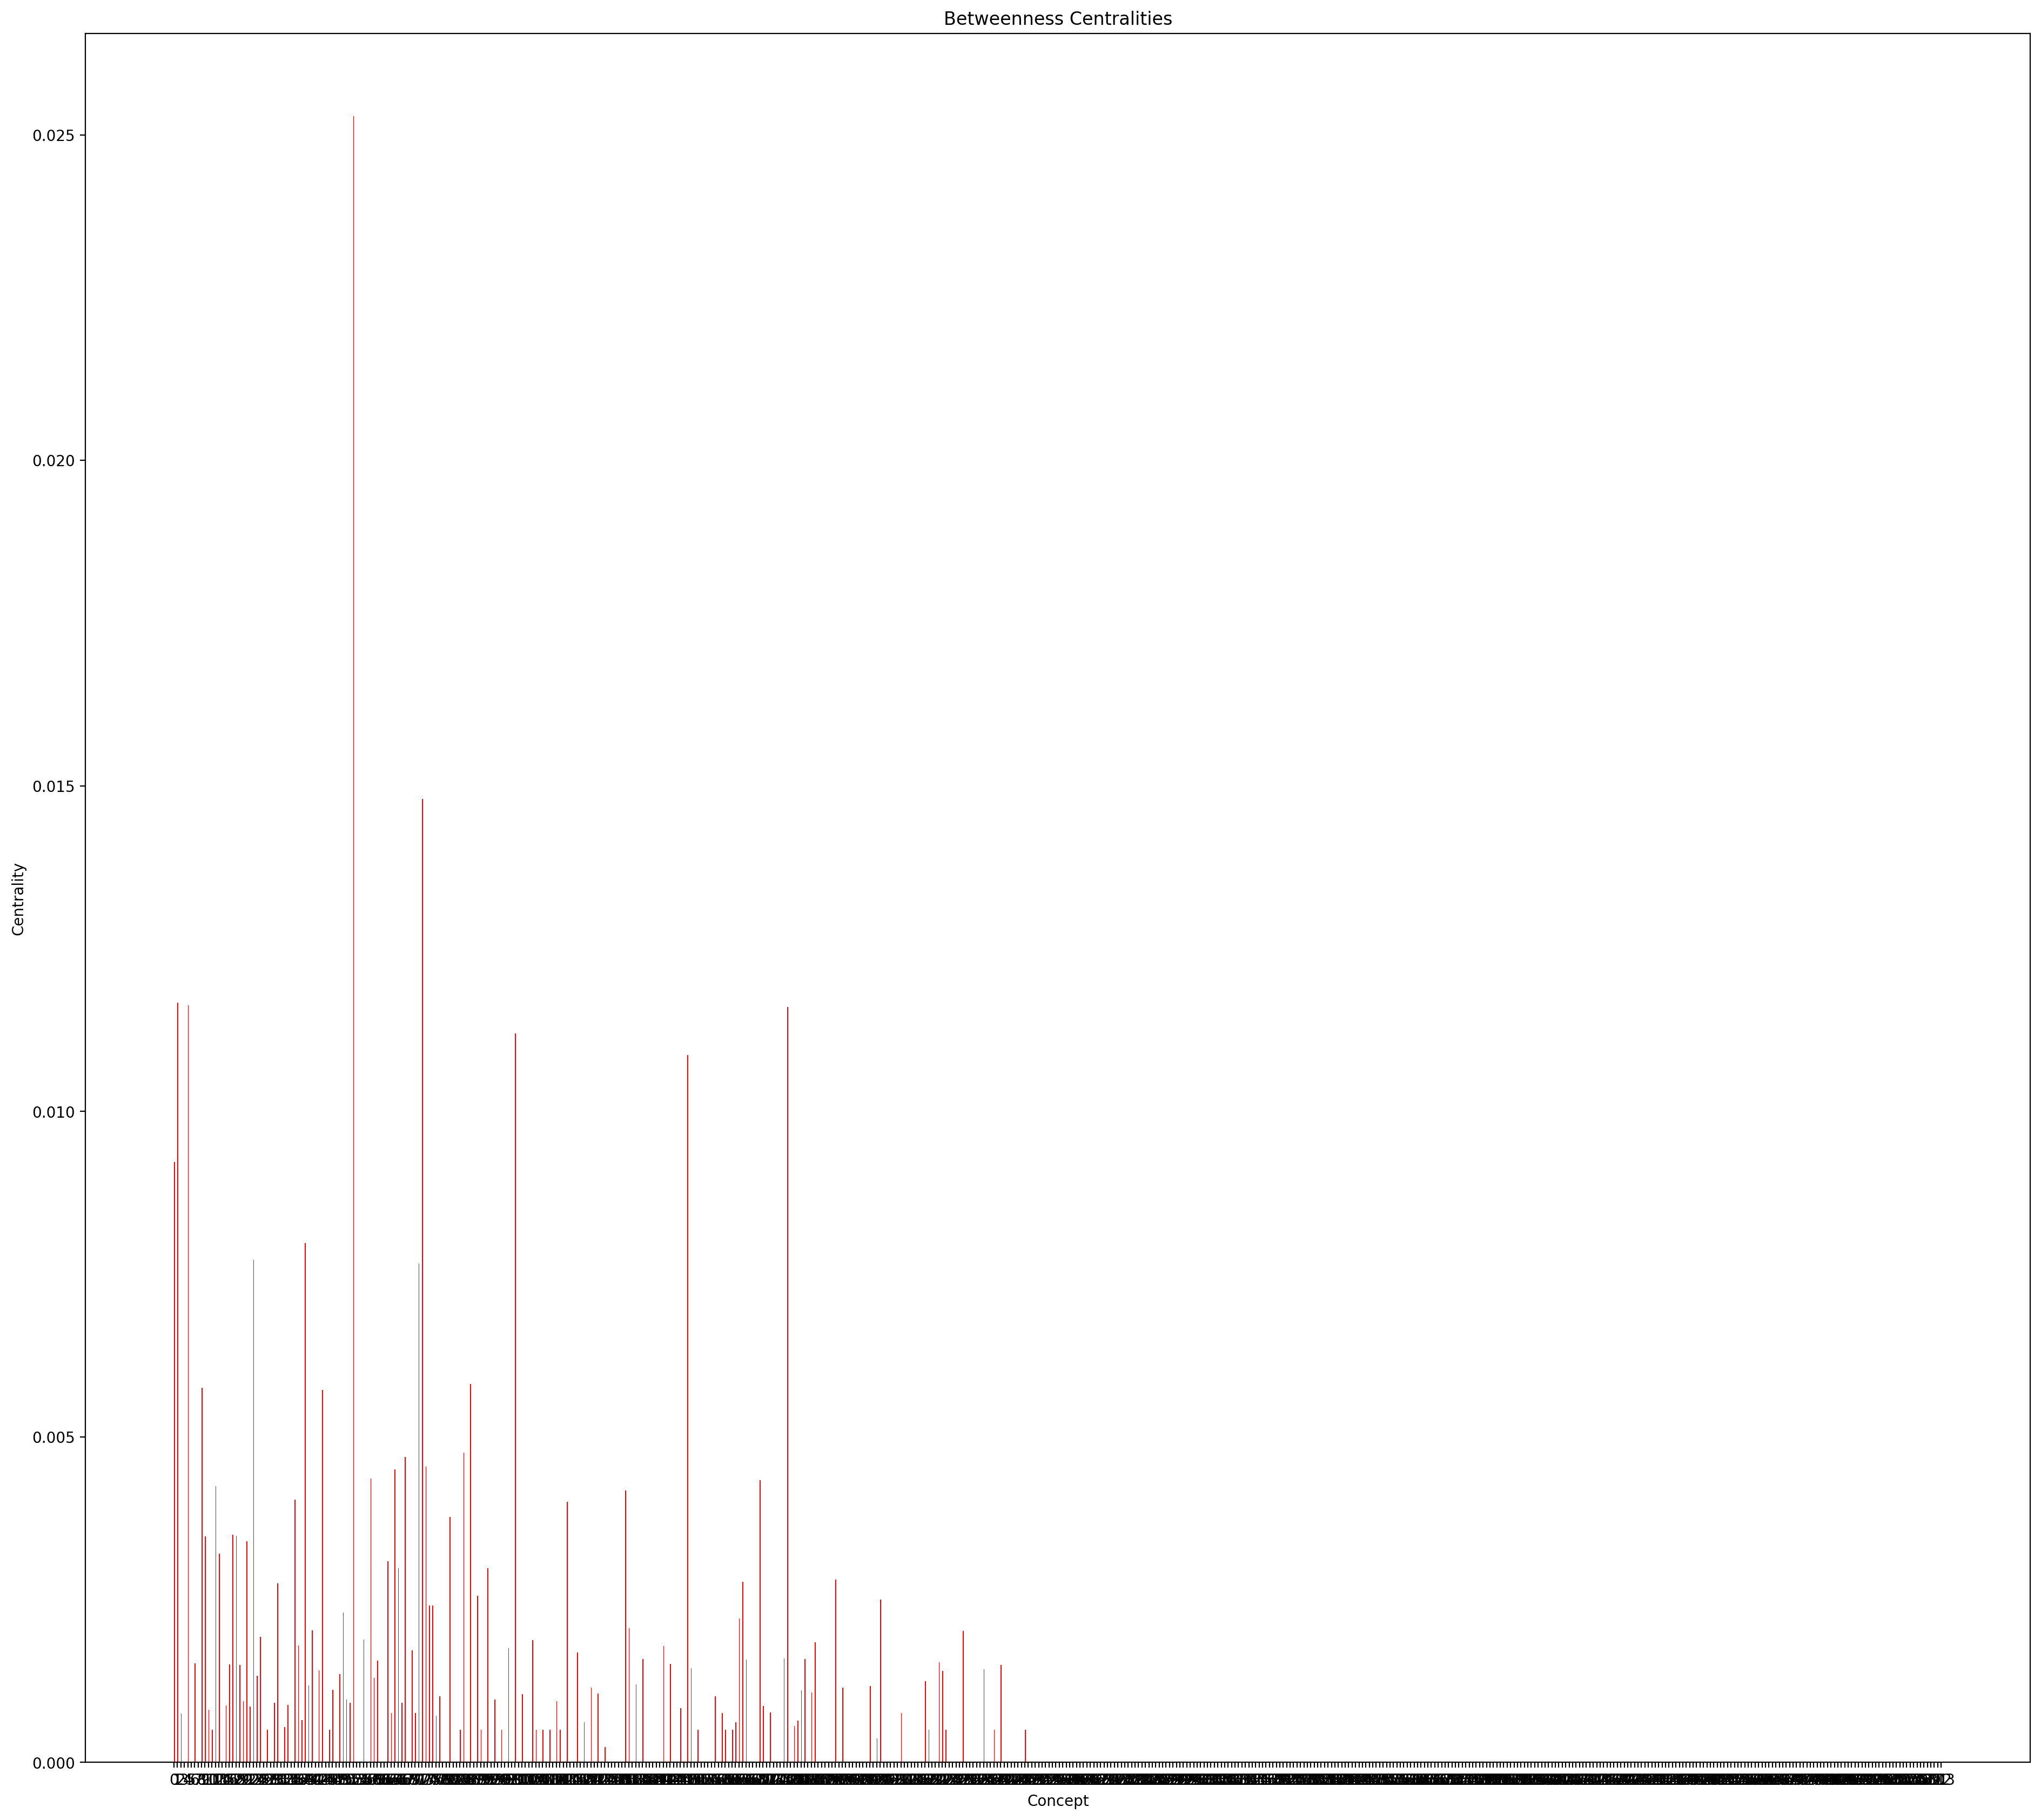

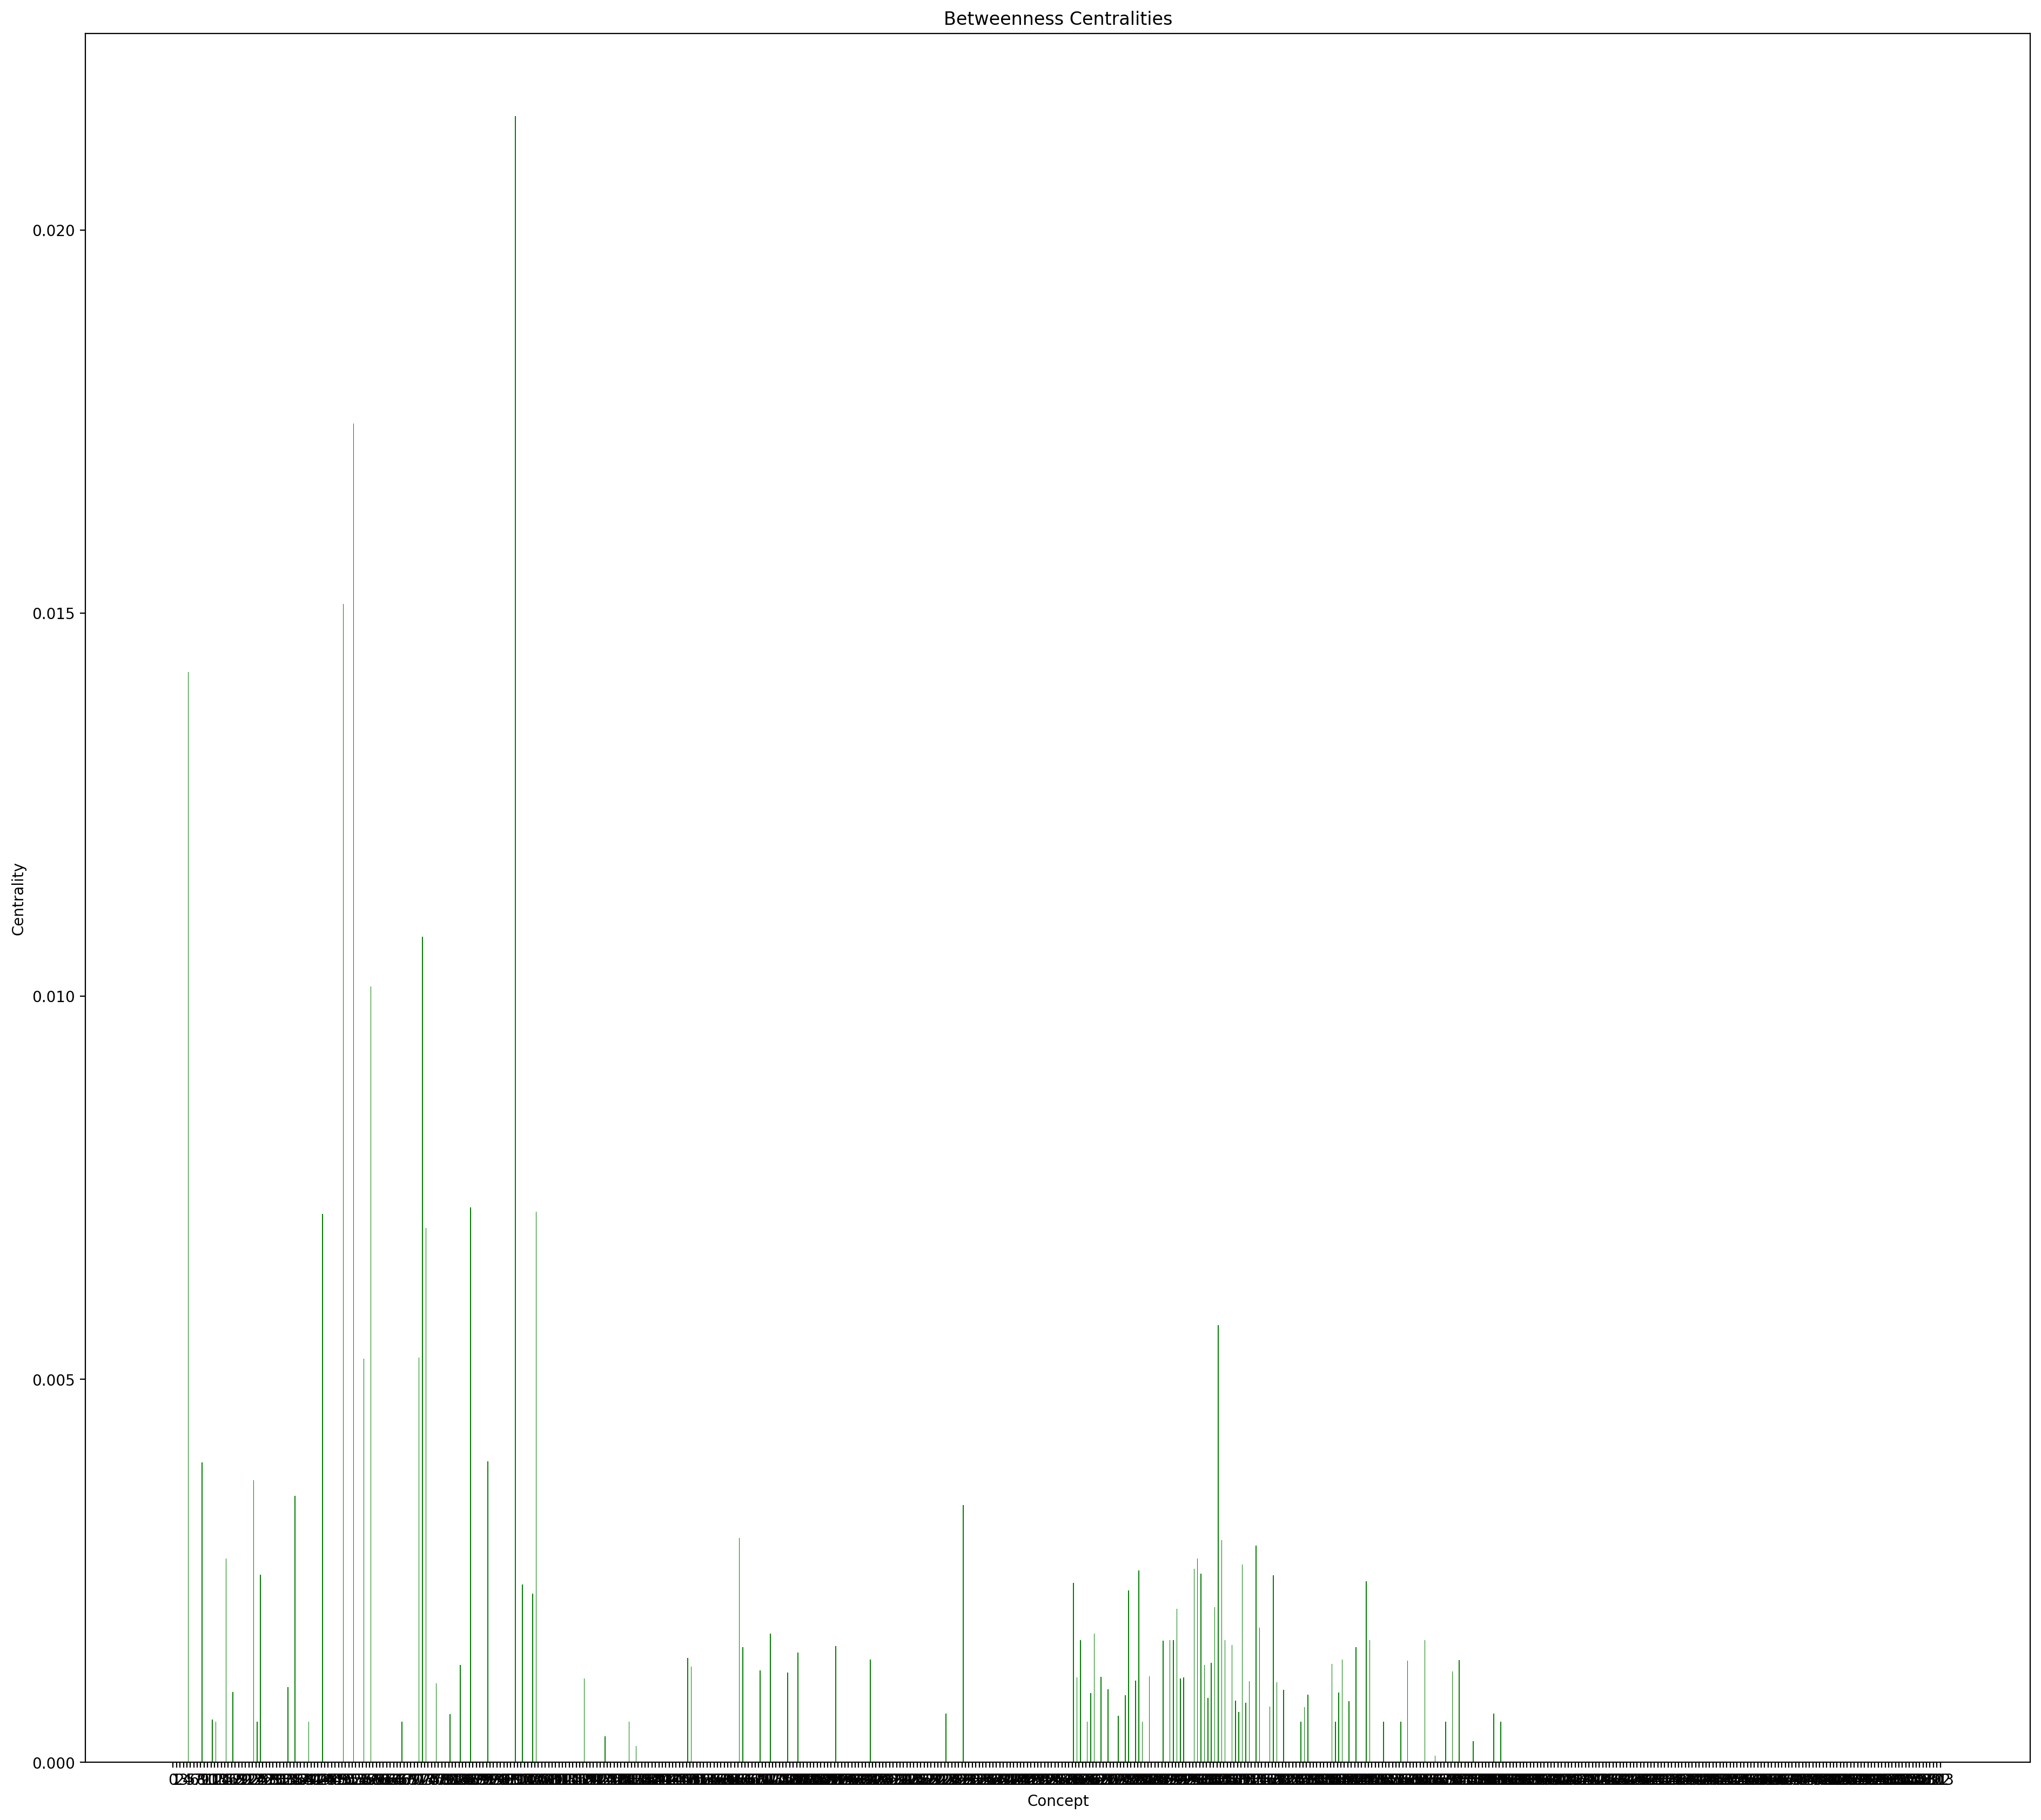

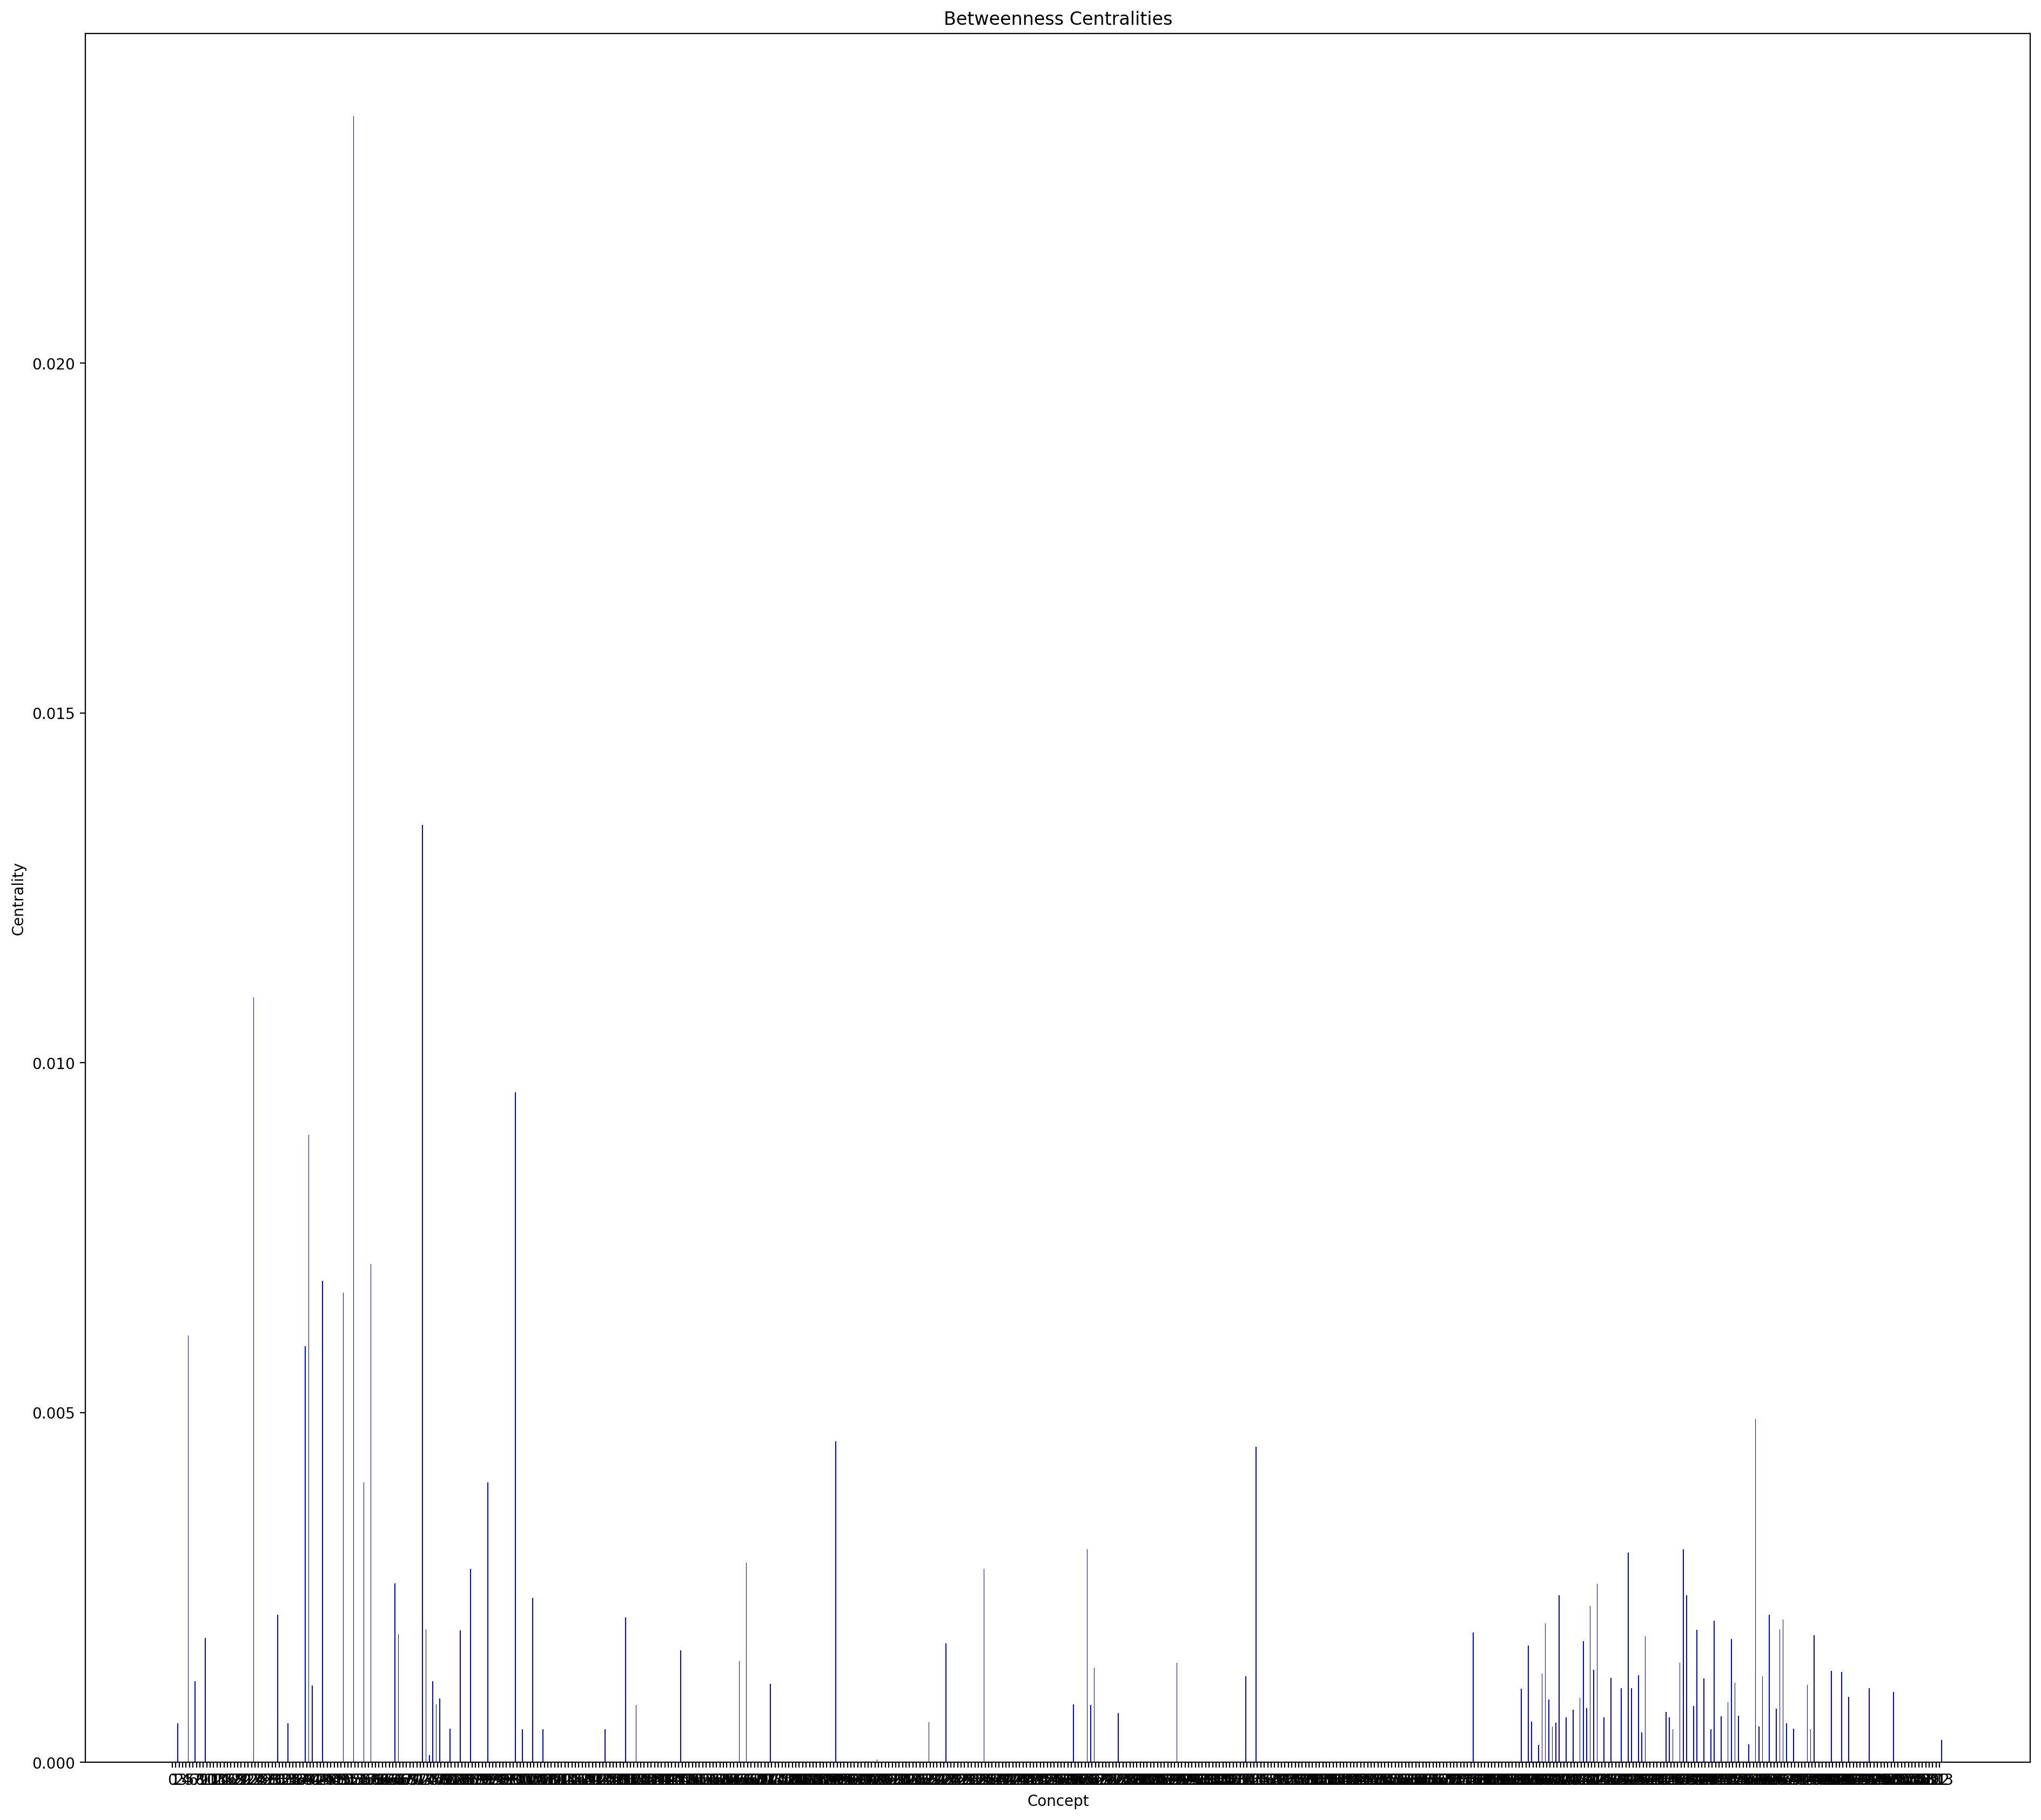

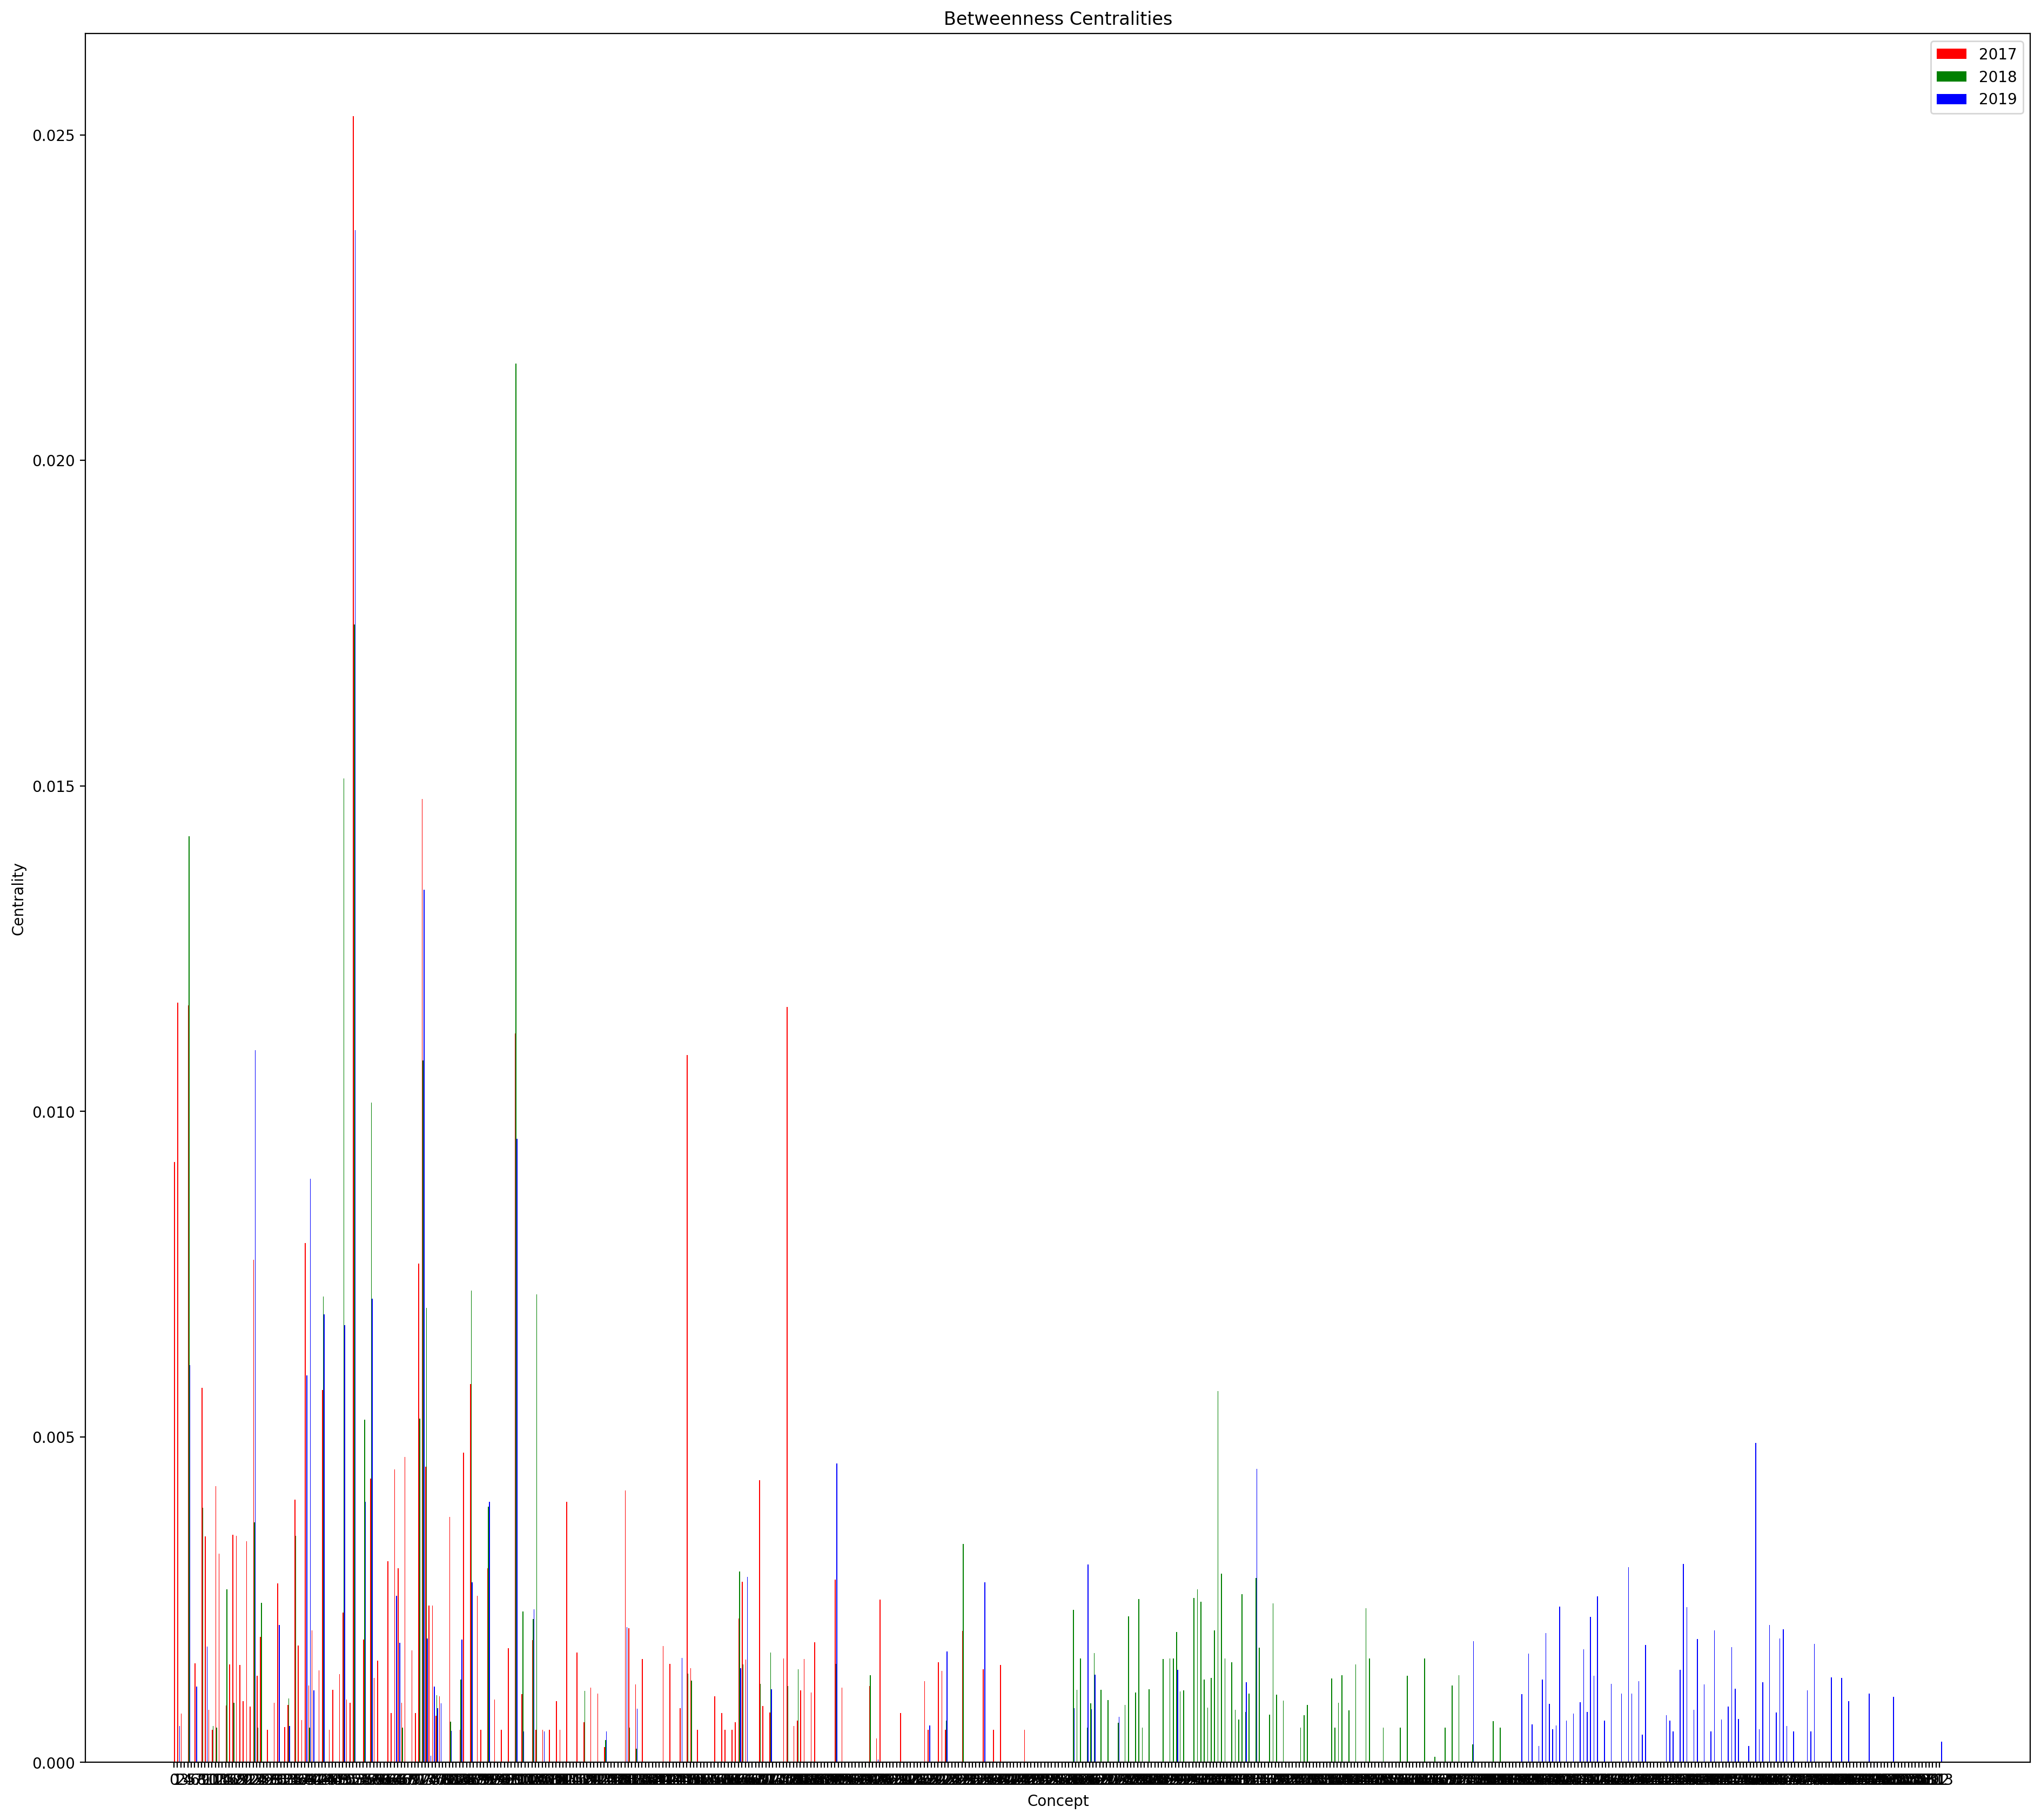

In [14]:
print('ALL BETWEENNESS CENTRALITIES')
plot_all(bet_centrality, 'Betweenness Centralities')

TOP BETWEENNESS CENTRALITIES
38
{rdflib.term.URIRef('http://local/local.owl#ontology'): [0.02528797196176485, 0.017478123883567457, 0.023533332644706383], rdflib.term.URIRef('http://local/local.owl#ontologies'): [0.014802080404017488, 0.010778475453609507, 0.01340041906024411], rdflib.term.URIRef('http://local/local.owl#description_logic'): [0.011670862738332543, 0, 0.0005616544401902658], rdflib.term.URIRef('http://local/local.owl#sparql'): [0.011629415763141379, 0.014229416603064943, 0.006103432114106641], rdflib.term.URIRef('http://local/local.owl#linked_data'): [0.01160170707970465, 0.0011748609207905593, 0], rdflib.term.URIRef('http://local/local.owl#rdf'): [0.011195367019267882, 0.021488393540841276, 0.009577681309261734], rdflib.term.URIRef('http://local/local.owl#social_media'): [0.010865577632288102, 0.001362178117505643, 0], rdflib.term.URIRef('http://local/local.owl#machine_translation'): [0.009223579542774455, 0, 0], rdflib.term.URIRef('http://local/local.owl#reasoning'): [

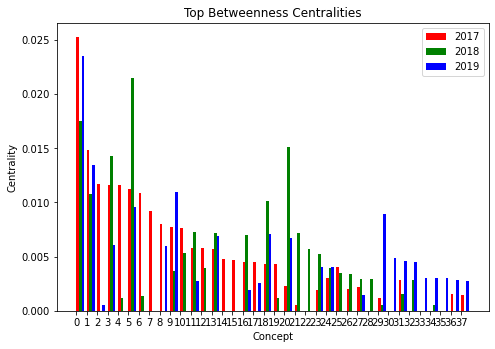

In [15]:
print('TOP BETWEENNESS CENTRALITIES')
print(len(top_bet_centrality))
print(top_bet_centrality)
plot_combined(top_bet_centrality, 'Top Betweenness Centralities')

BETWEENNESS CENTRALITY EXAMPLES
{rdflib.term.URIRef('http://local/local.owl#sparql'): [0.011629415763141379, 0.014229416603064943, 0.006103432114106641], rdflib.term.URIRef('http://local/local.owl#semantics'): [0.007716329705958226, 0.0036872171859808267, 0.010938726386710453], rdflib.term.URIRef('http://local/local.owl#sql'): [0.0008833452042782106, 0.0009811806745684893, 0.0005574337840327007], rdflib.term.URIRef('http://local/local.owl#natural_language_processing'): [0, 0.002346201918750622, 0.0008317950745723297], rdflib.term.URIRef('http://local/local.owl#machine_translation'): [0.009223579542774455, 0, 0], rdflib.term.URIRef('http://local/local.owl#feature_sets'): [0, 0.0011119112295724612, 0], rdflib.term.URIRef('http://local/local.owl#web_pages'): [0, 0, 0.0010503797959959935], rdflib.term.URIRef('http://local/local.owl#ontology'): [0.02528797196176485, 0.017478123883567457, 0.023533332644706383], rdflib.term.URIRef('http://local/local.owl#rdf'): [0.011195367019267882, 0.021488

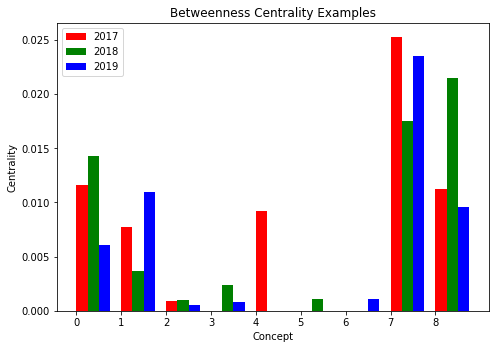

In [16]:
print('BETWEENNESS CENTRALITY EXAMPLES')
bet_examples = get_examples(bet_centrality)
plot_combined(bet_examples, 'Betweenness Centrality Examples')
print(bet_examples)